In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches as patch
import luxpy as lx
import tensorflow as tf
import tqdm
from scipy.signal import savgol_filter
import scipy
import os

In [2]:
path = "C:/Users/renep/Google Drive/Research/Dataset"
wavelength = np.arange(400,701,10)

cie = np.loadtxt(path + "/CIE1964.txt")
#x_, y_, z_ = cie[:,0], cie[:,1], cie[:,2], cie[:,3]
x_ = np.interp(wavelength, cie[:,0], cie[:,1])
y_ = np.interp(wavelength, cie[:,0], cie[:,2])
z_ = np.interp(wavelength, cie[:,0], cie[:,3])

'CAVE DATASET Sensitivity'

red = np.loadtxt(path + "/CAVE_RED.txt")
green = np.loadtxt(path + "/CAVE_GREEN.txt")
blue = np.loadtxt(path + "/CAVE_BLUE.txt")

r = savgol_filter(np.interp(wavelength, red[:,0], red[:,1]), 11, 2)
g = savgol_filter(np.interp(wavelength, green[:,0], green[:,1]), 11, 2)
b = savgol_filter(np.interp(wavelength, blue[:,0], blue[:,1]), 11, 2)

'D65 Illuminant'

D65 = lx._CIE_ILLUMINANTS['D65'] 
D65 = np.interp(wavelength, D65[0], D65[1])
D65 = D65/max(D65)
'Radiance'

light = np.loadtxt(path + "/LED.txt")
source = np.interp(wavelength, light[:,0], light[:,1])

'Munsell ensemble'

munsell_wav = np.arange(380,801,1)
munsell = np.loadtxt(path + "/munsell.txt")
munsell_r = np.zeros(shape=[len(wavelength),1269])

for i in range(1,1269):
    munsell_r[:,i] = np.interp(wavelength, munsell_wav, munsell[:,i])

'Macbeth Ensemble'
    
macbeth = np.loadtxt(path + "/macbeth.txt")
macbeth_wav, macbeth_ref =  macbeth[4:64,0], macbeth[4:64,1:]
macbeth_r = np.zeros(shape=[len(wavelength),24])


for i in range(1,25):
    macbeth_r[:,i-1] = np.interp(wavelength, macbeth_wav, macbeth_ref[:,i-1])
    
    
'Filter transmittances'
f = 1

filters = np.loadtxt(path + "/filter.txt")

epochs = ["50","100","1000","5000","10000"]

In [3]:
def Color_Simulation(r_sensitivity,g_sensitivity,b_sensitivity, source, transmittance, ensemble):

    
    R_sim = []
    G_sim = []
    B_sim = []
    
    for i in range(0,len(ensemble.T)):

        R = np.trapz(ensemble[:,i]*r_sensitivity*source*transmittance)
        G = np.trapz(ensemble[:,i]*g_sensitivity*source*transmittance)
        B = np.trapz(ensemble[:,i]*b_sensitivity*source*transmittance)
        
        R_sim.append(R)
        G_sim.append(G)
        B_sim.append(B)
            
    RGB = np.array([np.round(255*(R_sim/max(R_sim))),
                    np.round(255*(G_sim/max(G_sim))),
                    np.round(255*(B_sim/max(B_sim)))])
            
    return RGB 

In [4]:
RGB_mac = Color_Simulation(r,g,b,D65, 1, macbeth_r)
RGB_mun = Color_Simulation(r,g,b,D65, 1, munsell_r)

In [5]:
def objects(path = "C:/Users/renep/Google Drive/Research/Codes/_FINAL CODES"):
    object  = os.listdir(path)
    #names.append()
    return object

MODELS = objects()

def dataset_loader(datatype, imagetype):
    #datatype = "datatype"
    def loadImages(path = "C:/Users/renep/Google Drive/Research/Codes/Latest Models" +str(datatype)+"/"+ str(datatype)+"/"):

        return[os.path.join(path,f) for f in os.listdir(path) if f.endswith(imagetype)]

    filenames = loadImages()
    
    images = []
    for file in filenames:
        images.append(plt.imread(file))
        
    return images

In [6]:
MODELS = MODELS[4:-2]
MODELS

['MODEL1.model', 'MODEL2.model', 'MODEL3.model', 'MODEL4.model']

In [7]:
#munsell_trained_models = ["munsell_X.model", "munsell_X_100.model",
#                         "munsell_X_1000.model", "munsell_X_5000.model","munsell_X_10000.model"]
RGB_models = []

for model in MODELS:
    RGB2REF = tf.keras.models.load_model(model)
    reflectances = RGB2REF.predict(RGB_mac.T)
    
    RGB = Color_Simulation(r,g,b,1,1, reflectances.T)
    RGB_models.append(RGB/255)

In [8]:
def f(t):
    if t > (6/29)**3:
        return t**(1/3)
    else:
        return (((29/6)**2)/3)*t + 4/29
    
def CIELab(spectrum):

    X_n = np.trapz(D65*x_)
    Y_n = np.trapz(D65*y_)
    Z_n = np.trapz(D65*z_)
    
    X = np.trapz(spectrum*D65*x_)
    Y = np.trapz(spectrum*D65*y_)
    Z = np.trapz(spectrum*D65*z_)
        
    L = 116*f(Y/Y_n)-16
    a = 500*(f(X/X_n)-f(Y/Y_n))
    b = 200*(f(Y/Y_n)-f(Z/Z_n))

    return L,a,b

def del_E(LAB_1,LAB_2):
    d_e = np.sqrt((LAB_1[0]-LAB_2[0])**2 + (LAB_1[1]-LAB_2[1])**2 + (LAB_1[2]-LAB_2[2])**2)
    return d_e

def del_E_94(LAB_1,LAB_2):
    
    L1, L2 = LAB_1[0], LAB_2[0]
    a1, a2 = LAB_1[1], LAB_2[1]
    b1, b2 = LAB_1[2], LAB_2[2]
    C1 = np.sqrt(a1**2 + b1**2)
    C2 = np.sqrt(a2**2 + b2**2)
    del_L = L1-L2
    del_C = C1-C2
    del_H = np.sqrt((a1-a2)**2 + (b1-b2)**2 - del_C)
    
    SL = 1
    SC = 1 + 0.045*(np.sqrt(C1*C2))
    SH = 1 + 0.015*(np.sqrt(C1*C2))
    
    d_e = np.sqrt((del_L)**2 + (del_C/SC)**2 + (del_H/SH)**2)
    
    return d_e

In [9]:
def Lum(t):
    if t < (6/29)**3:
        return t*((29/3)**3)
    else:
        return 116*(np.cbrt(t)) - 16
    
def CIELuv(spectrum):

    X_n = np.trapz(D65*x_)
    Y_n = np.trapz(D65*y_)
    Z_n = np.trapz(D65*z_)
    
    X = np.trapz(spectrum*D65*x_)
    Y = np.trapz(spectrum*D65*y_)
    Z = np.trapz(spectrum*D65*z_)
    
    k = 100/Y_n
    X_n, Y_n, Z_n = k*X_n, k*Y_n, k*Z_n
    X, Y, Z = k*X, k*Y, k*Z
    
    u = 4*X/(X+15*Y+3*Z)
    v = 9*Y/(X+15*Y+3*Z)
    
    u_n = 4*X_n/(X_n+15*Y_n+3*Z_n)
    v_n = 9*Y_n/(X_n+15*Y_n+3*Z_n)
    
        
    L = Lum(Y/Y_n)
    u_ = 13*L * (u - u_n)
    v_ = 13*L * (v - v_n)


    return L,u_,v_

In [10]:
def Error(model):
    RGB2REF = tf.keras.models.load_model(model)
    predictions = RGB2REF.predict(RGB_mac.T)
    

    RMSE = []
    SAM = []
    DE_76 = []
    DE_CH_ab = []
    DE_CH_uv = []
    for i in range(24):
        x = predictions[i,:]
        y = macbeth_r[:,i]
        
        de_76 = del_E(CIELab(y),CIELab(x))
        de_CH_ab = del_E_94(CIELab(y),CIELab(x))
        de_CH_uv = del_E(CIELuv(y),CIELuv(x))
        
        mse = sum((x-y)**2)/len(x)
        rmse = np.sqrt(mse)
        alpha = np.arccos(sum(x*y)/(np.sqrt(sum(x**2))*(np.sqrt(sum(y**2)))))
        
        RMSE.append(rmse)
        SAM.append((alpha))
        DE_76.append(de_76)
        DE_CH_ab.append(de_CH_ab)
        DE_CH_uv.append(de_CH_uv)


        
    return RMSE, SAM, DE_76, DE_CH_ab, DE_CH_uv

In [12]:
results_path = "C:/Users/renep/Google Drive/Research/THESIS RESULTS/Macbeth Results/"


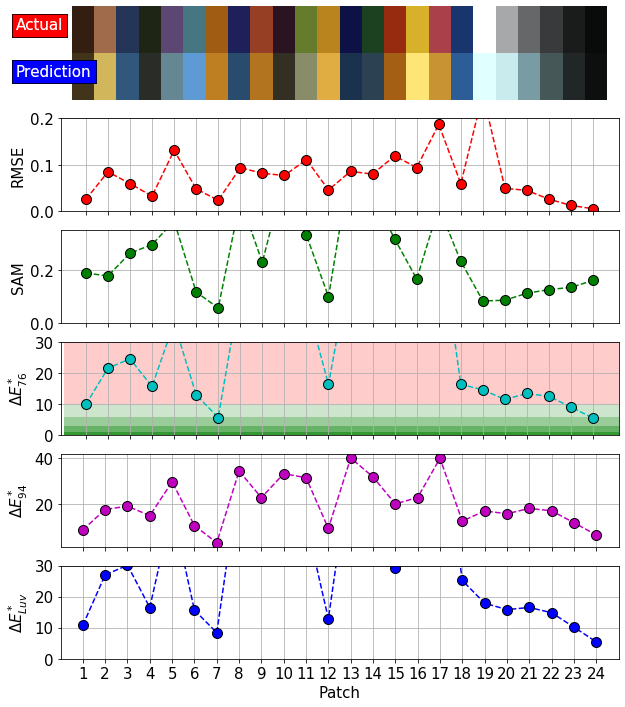

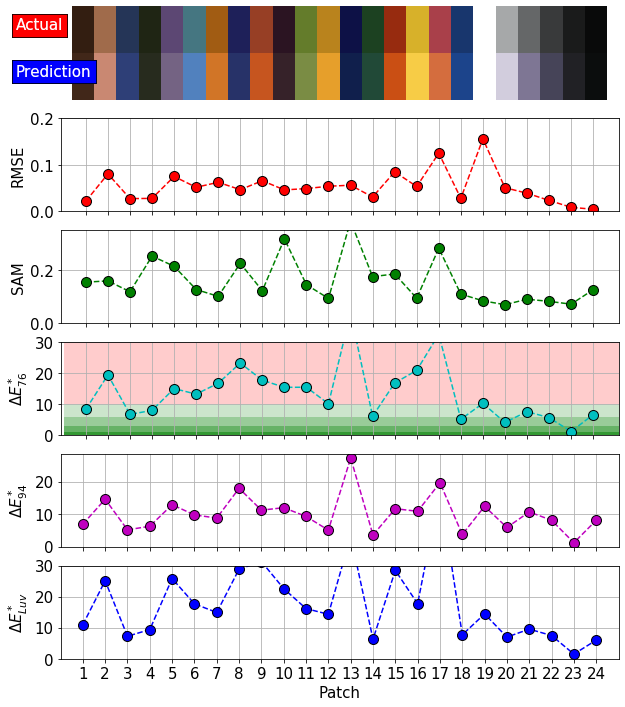

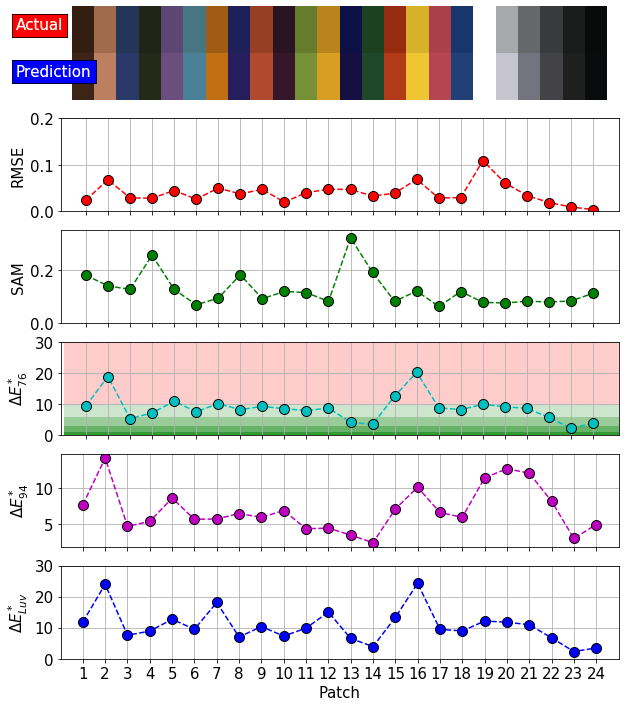

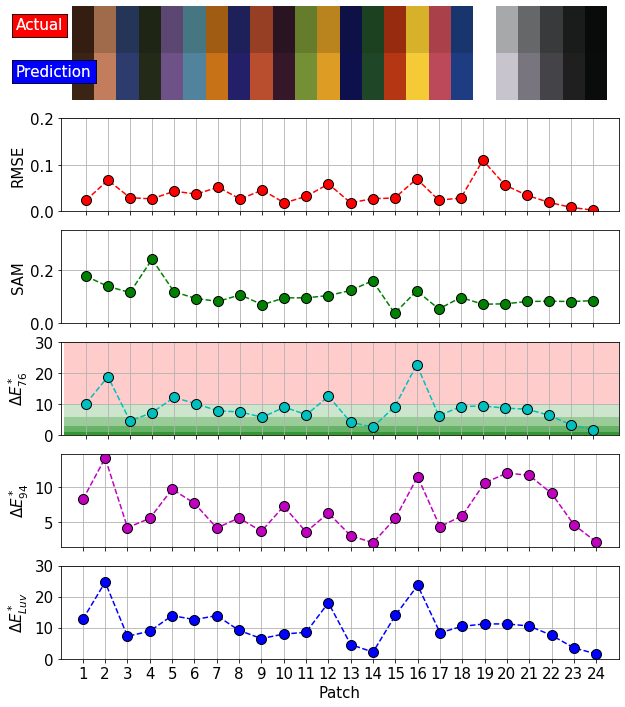

In [13]:
#munsell_trained_models = ["munsell_X.model", "munsell_X_100.model",
#                         "munsell_X_1000.model", "munsell_X_5000.model","munsell_X_10000.model"]

RMSE_mean, SAM_mean, DE_76_mean, DE_CH_ab_mean, DE_CH_uv_mean = [], [], [], [], []
RMSE_std, SAM_std, DE_76_std, DE_CH_ab_std, DE_CH_uv_std = [], [], [], [], []


for models in MODELS:
    
    mod = MODELS.index(models)
    #epoch = epochs[mod]
    RMSE, SAM, DE_76, DE_CH_ab, DE_CH_uv = Error(models)
    
    RMSE_mean.append(np.mean(RMSE))
    RMSE_std.append(np.std(RMSE))
    SAM_mean.append(np.mean(SAM))
    SAM_std.append(np.std(SAM))
    DE_76_mean.append(np.mean(DE_76))
    DE_76_std.append(np.std(DE_76))
    DE_CH_ab_mean.append(np.mean(DE_CH_ab))
    DE_CH_ab_std.append(np.std(DE_CH_ab))
    DE_CH_uv_mean.append(np.mean(DE_CH_uv))
    DE_CH_uv_std.append(np.std(DE_CH_uv))

    plt.figure(figsize=[10,12], facecolor = 'w')
    plt.rcParams['axes.titlesize'] = 15
    plt.rcParams.update({'font.size': 15})
    #plt.suptitle("Spectral and Colorimetric Accuracy (Model " + str(mod+1) + ")")

    ax1 = plt.subplot(611)
    for i in range(24):
        plt.gca().add_patch(patch.Rectangle((i+0.5,0),1,0.5, facecolor = RGB_models[MODELS.index(models)][:,i]))
        plt.gca().add_patch(patch.Rectangle((i+0.5,0.5),1,0.5, facecolor = RGB_mac[:,i]/255))
        plt.text(-2,0.25, "Prediction", fontsize = 15, color = 'w',bbox=dict(facecolor='b', alpha=0.5))
        plt.text(-2,0.75, "Actual", fontsize = 15, color = 'w',bbox=dict(facecolor='r', alpha=0.5))

    plt.xticks(np.arange(24)+1)
    plt.xlim(0,25)
    plt.setp(ax1.get_yticklabels(), visible=False)
    plt.axis("off")

    ax2 = plt.subplot(612)
    plt.plot(np.arange(24)+1,RMSE, 'ro--', ms = 10, mec = 'k')
    plt.grid()
    plt.ylabel("RMSE")
    plt.xticks(np.arange(24)+1)
    plt.ylim(0,0.2)
    plt.setp(ax2.get_xticklabels(), visible=False)

    ax3 = plt.subplot(613)
    plt.plot(np.arange(24)+1,SAM, 'go--', ms = 10, mec = 'k')
    plt.grid()
    plt.ylabel("SAM")
    plt.ylim(0,0.35)
    plt.xticks(np.arange(24)+1)
    plt.setp(ax3.get_xticklabels(), visible=False)

    ax4 = plt.subplot(614)
    plt.plot(np.arange(24)+1,DE_76, 'co--', ms = 10, mec = 'k')
    plt.grid()
    plt.ylabel("$\Delta E^*_{76}$")
    plt.gca().add_patch(patch.Rectangle((0,0),26,1, facecolor = 'g', alpha = 0.8))
    plt.gca().add_patch(patch.Rectangle((0,1),26,2, facecolor = 'g', alpha = 0.6))
    plt.gca().add_patch(patch.Rectangle((0,3),26,3, facecolor = 'g', alpha = 0.4))
    plt.gca().add_patch(patch.Rectangle((0,6),26,4, facecolor = 'g', alpha = 0.2))
    plt.gca().add_patch(patch.Rectangle((0,10),26,20, facecolor = 'r', alpha = 0.2))

    plt.xticks(np.arange(24)+1)
    plt.ylim(0,30)
    plt.setp(ax4.get_xticklabels(), visible=False)

    ax5 = plt.subplot(615, sharex=ax1)
    plt.plot(np.arange(24)+1,DE_CH_ab, 'mo--', ms = 10, mec = 'k')
    plt.grid()
    plt.setp(ax5.get_xticklabels(), visible=False)
    plt.ylabel("$\Delta E^*_{94}$")
    #plt.ylim(0,25)
    plt.xticks(np.arange(24)+1)
    plt.xlim(0,25)
                            
    ax6 = plt.subplot(616, sharex=ax1)
    plt.plot(np.arange(24)+1,DE_CH_uv, 'bo--', ms = 10, mec = 'k')
    plt.grid()
    plt.xlabel("Patch")
    plt.ylabel("$\Delta E^*_{Luv}$")
    plt.ylim(0,30)
    plt.xticks(np.arange(24)+1)
    plt.xlim(0,25)


                        
    plt.tight_layout
    plt.savefig(results_path + "Macbeth_Accuracy" + str(MODELS.index(models)) + ".png", dpi = 200, bbox_inches='tight', transparent=True)
    plt.show()


In [14]:
RMSE_mean, SAM_mean, DE_76_mean, DE_CH_ab_mean, DE_CH_uv_mean

([0.07658246644747564,
  0.05310062849719327,
  0.03964287465742768,
  0.03728535805823541],
 [0.25418416081306855,
  0.15780042276407777,
  0.1250644240018346,
  0.1045458467135565],
 [26.164268980436713,
  13.542724413279926,
  8.701462446349723,
  8.506370339462235],
 [20.312258254205922,
  10.134233243514414,
  6.983968275318449,
  6.791461920414112],
 [29.63078117734467,
  17.687383914499463,
  10.681696271189248,
  10.543344908963109])

In [15]:
RMSE_std, SAM_std, DE_76_std, DE_CH_ab_std, DE_CH_uv_std

([0.05504659440368514,
  0.033571762555297514,
  0.02159542712422695,
  0.022695242209704824],
 [0.15567762901121435,
  0.08139407324654176,
  0.06100927303418796,
  0.04184160748595708],
 [16.67530725425132, 8.883174306051272, 4.081855991414441, 4.6088896462920905],
 [10.307293321565083, 5.624217062409689, 3.067330672831995, 3.373481887111045],
 [19.09000464919641,
  12.171839982948388,
  5.386777262608249,
  5.6367781460992825])

$\Delta E_{76}$

In [17]:
MODELS

['MODEL1.model', 'MODEL2.model', 'MODEL3.model', 'MODEL4.model']

In [18]:
plt.rcParams['axes.titlesize'] = 15
plt.rcParams.update({'font.size': 16})

In [21]:
def Render_WB(model, r_sensitivity,g_sensitivity,b_sensitivity, source):
    RGB2REF = tf.keras.models.load_model(model)
    reflectances = RGB2REF.predict(RGB_mac.T)
    
    mod = MODELS.index(model)
    #epoch = epochs[mod]

    fig, axes = plt.subplots(4,6, figsize=(15,9), sharex=True, sharey=True, dpi=200, facecolor = 'w')
  
    #fig, axes = plt.subplots(3,6, figsize=(12,6), sharex=True, sharey=True, dpi=100, facecolor = 'w')

    R_w = np.trapz(reflectances[18,:]*r_sensitivity*source)
    G_w = np.trapz(reflectances[18,:]*g_sensitivity*source)
    B_w = np.trapz(reflectances[18,:]*b_sensitivity*source)


    R_m_w = np.trapz(macbeth_r[:,18]*r_sensitivity*source)
    G_m_w = np.trapz(macbeth_r[:,18]*g_sensitivity*source)
    B_m_w = np.trapz(macbeth_r[:,18]*b_sensitivity*source)

    RGB = []
    for i, ax in enumerate(axes.ravel()):
        
        de_76 = del_E(CIELab(reflectances[i,:]),CIELab(macbeth_r[:,i]))
    
        

        R = 255/R_w*np.trapz(reflectances[i,:]*r_sensitivity*source)
        G = 255/G_w*np.trapz(reflectances[i,:]*g_sensitivity*source)
        B = 255/B_w*np.trapz(reflectances[i,:]*b_sensitivity*source)
        
        R_m = 255/R_m_w*np.trapz(macbeth_r[:,i]*r_sensitivity*source)
        G_m = 255/G_m_w*np.trapz(macbeth_r[:,i]*g_sensitivity*source)
        B_m = 255/B_m_w*np.trapz(macbeth_r[:,i]*b_sensitivity*source) 
        
        if R<0: R = 0
        if G<0: G = 0
        if B<0: B = 0
        if R>255: R = 255
        if G>255: G = 255
        if G>255: B = 255
        
        fig.suptitle("Color Rendition (Model " + str(mod+1) + ")")
        
        ax.plot(wavelength, macbeth_r[:,i], 'w-', lw = 5 )
        ax.plot(wavelength, macbeth_r[:,i], 'r--', lw = 3, label = 'Actual')
        ax.plot(wavelength, reflectances[i,:], 'w-', lw = 5 )
        ax.plot(wavelength, reflectances[i,:], 'b--', lw = 3, label = 'Predicted')
        ax.set_xlabel("$\Delta$E$_{76}$ = " + str(np.round(de_76,2)))

        rr,gg,bb = R/255,G/255,B/255
        rr_m,gg_m,bb_m = R_m/255,G_m/255,B_m/255
        
        if rr<0: rr = 0
        if gg<0: gg = 0
        if gg<0:  bb = 0
        if rr>1: rr = 1
        if gg>1: gg = 1
        if bb>1: bb = 1
        
        #print(rr,gg,bb)
        ax.set_facecolor([rr,gg,bb])
             
        ax.set_xlim(400,700)
        ax.set_ylim(0,1)
        ax.set_xticks([450,650])
        ax.set_yticks([0.5,1])

        rect = patch.Rectangle((400,0),150,1,facecolor=([rr_m,gg_m,bb_m])) 
        rect2 = patch.Rectangle((550,0),150,1,facecolor=([rr,gg,bb])) 
        ax.add_patch(rect)
        ax.add_patch(rect2)
        RGB.append([rr,gg,bb])
    
        

    legend = ax.legend(bbox_to_anchor=(0.95,5.2), fancybox = True)
    frame = legend.get_frame() #sets up for color, edge, and transparency
    frame.set_facecolor('#b4aeae') #color of legend
    frame.set_edgecolor('black') #edge color of legend
    frame.set_alpha(1) #deals with transparency
    fig.savefig(results_path + model + ".png", bbox_inches='tight', transparent=True)
    

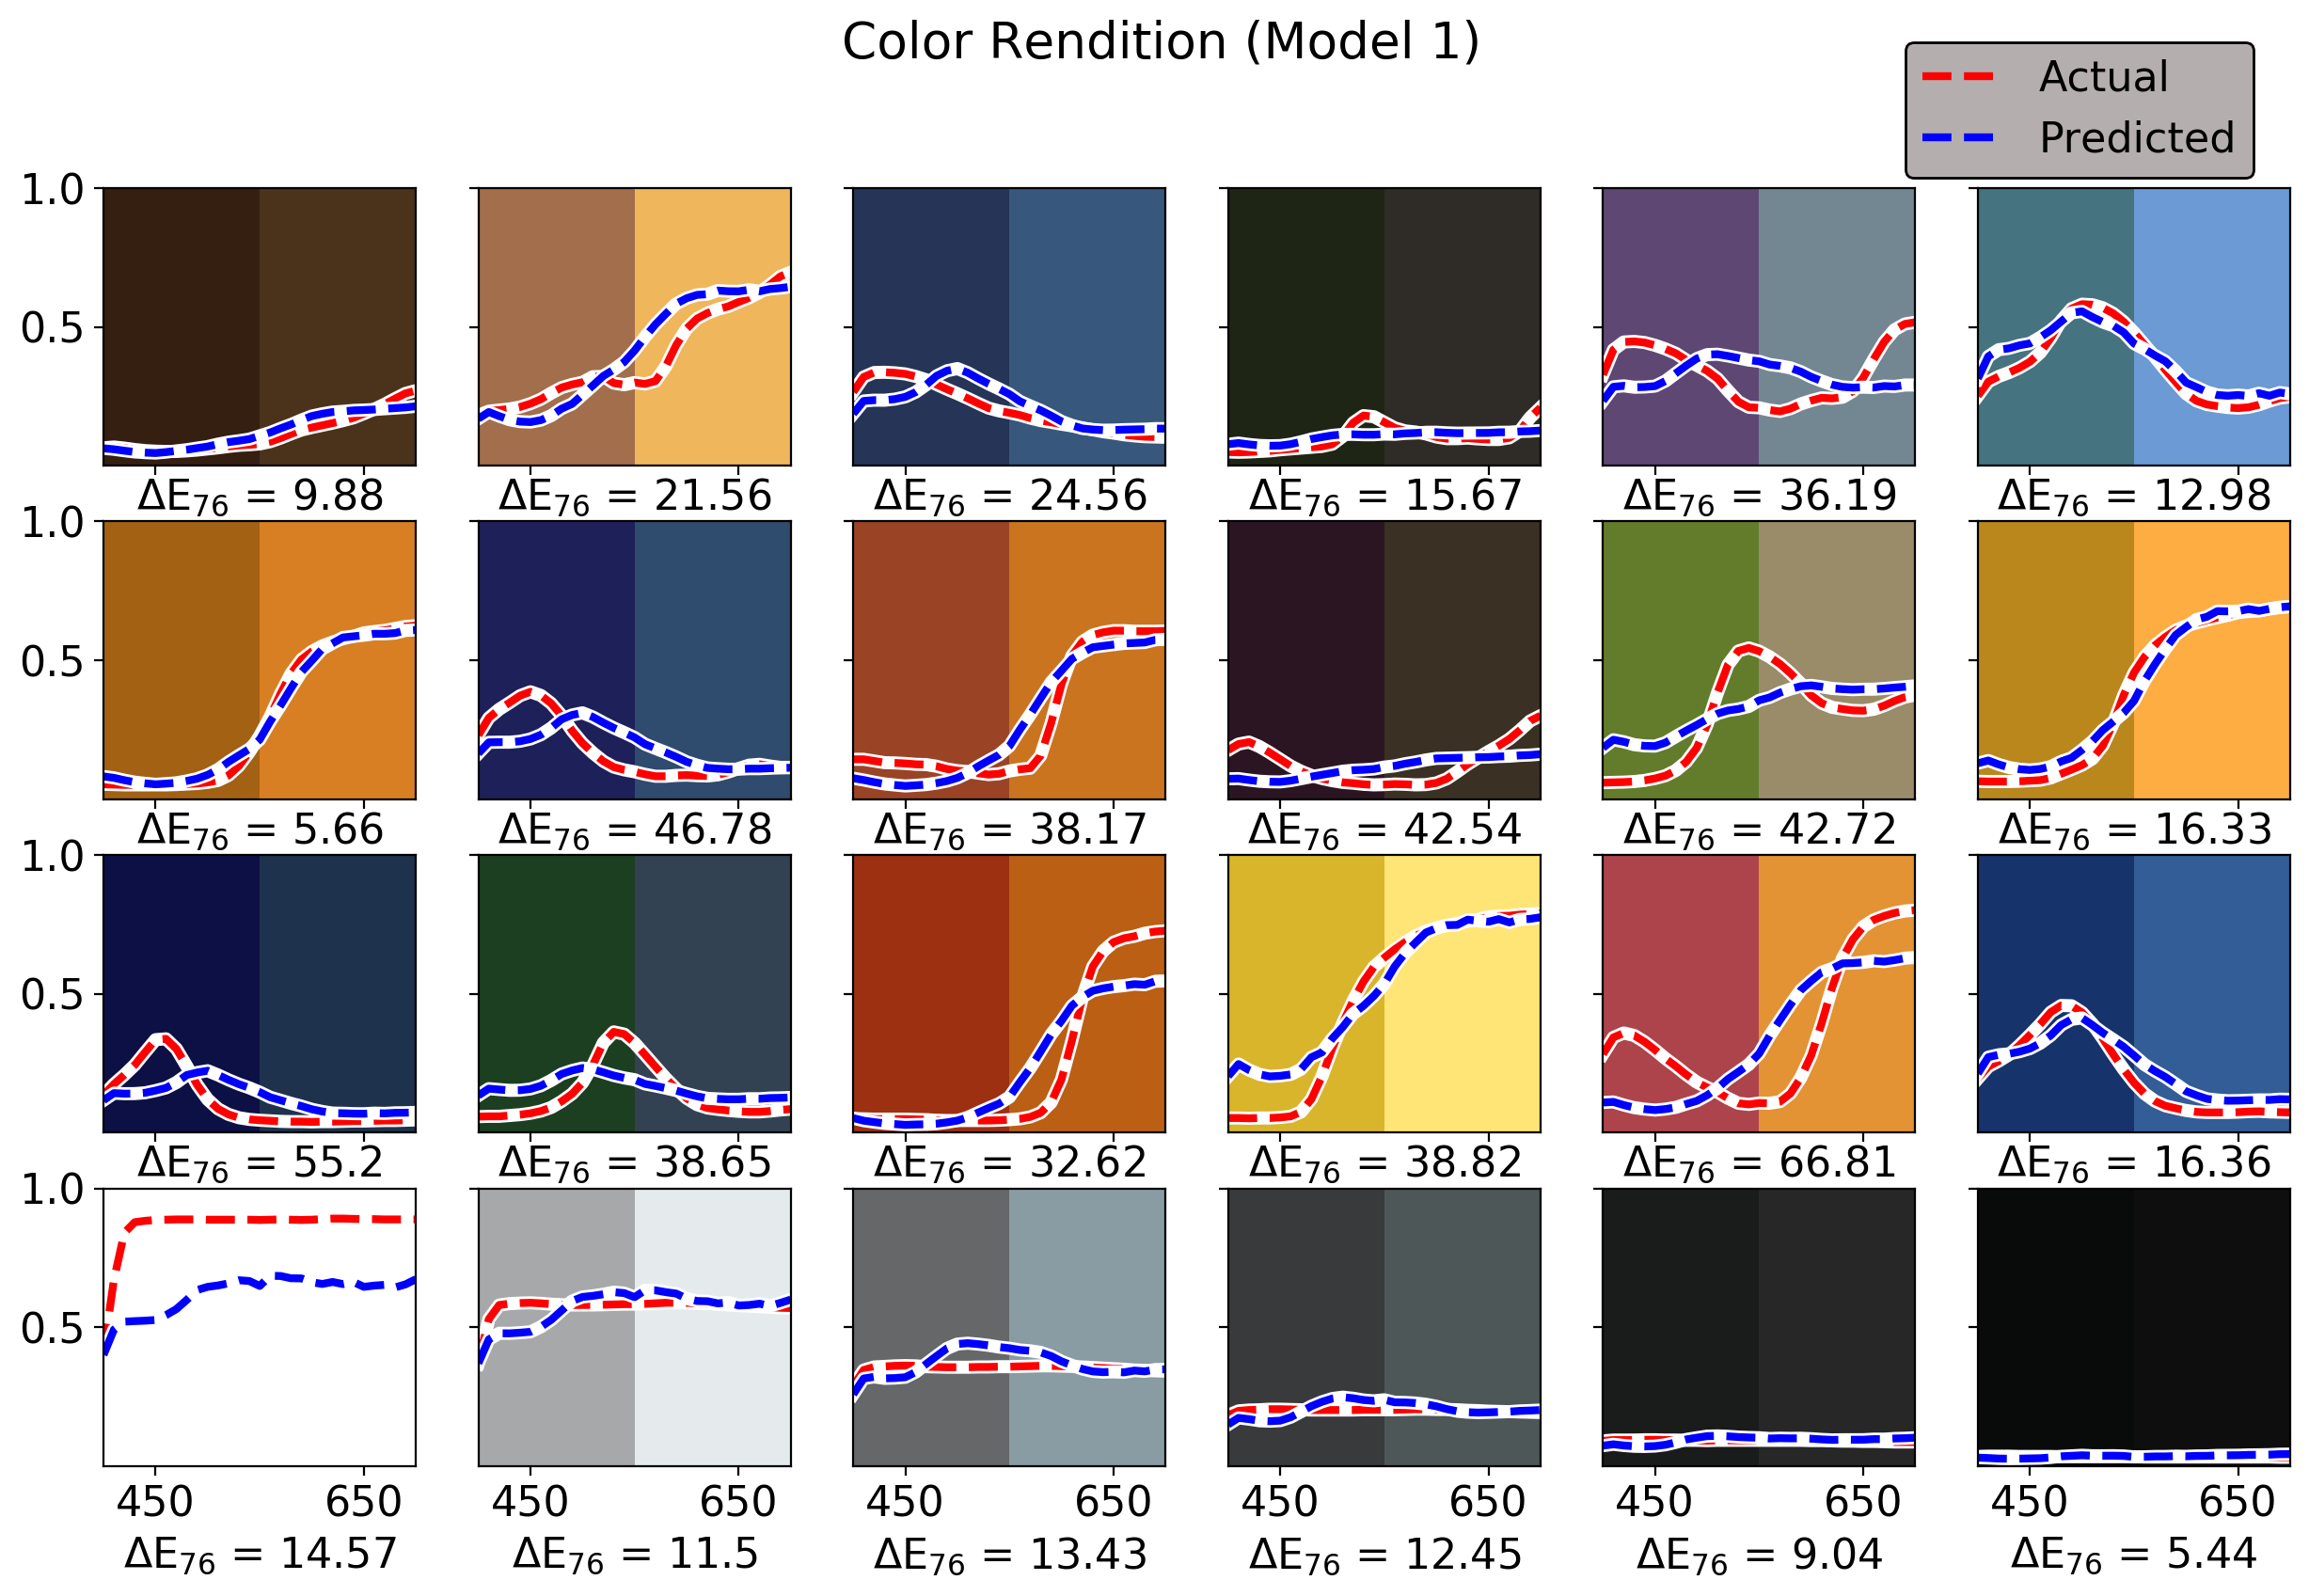

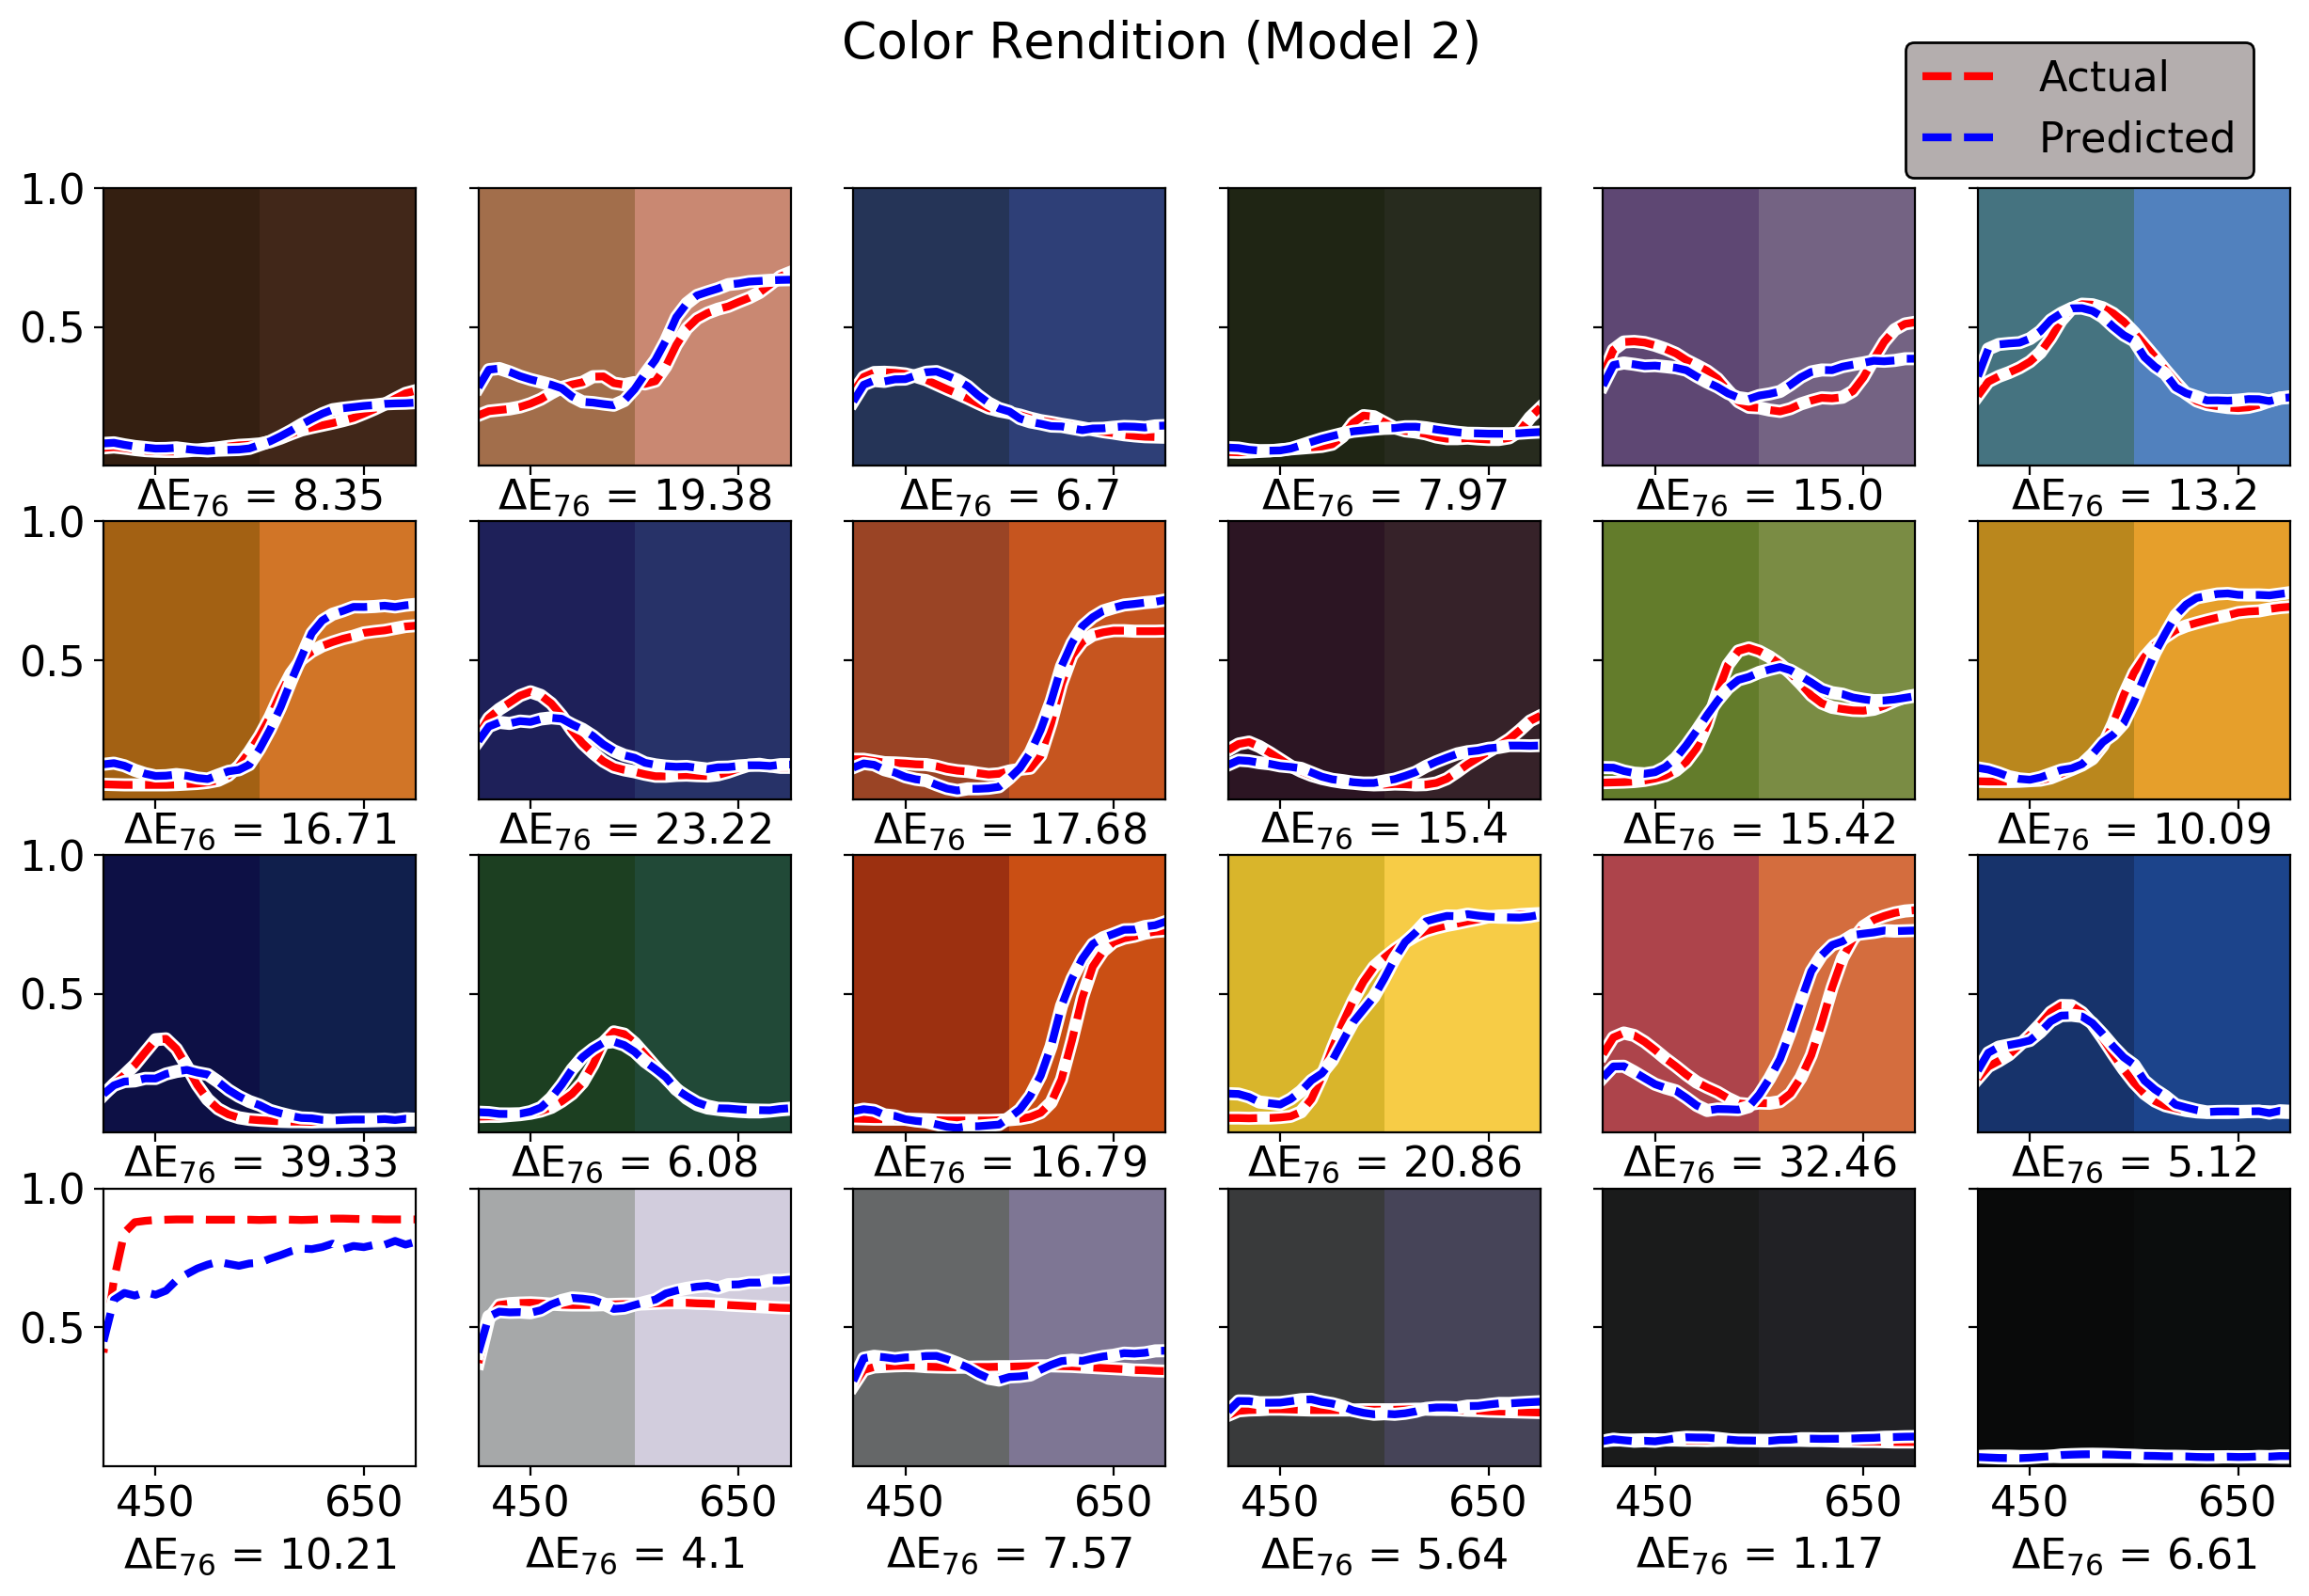

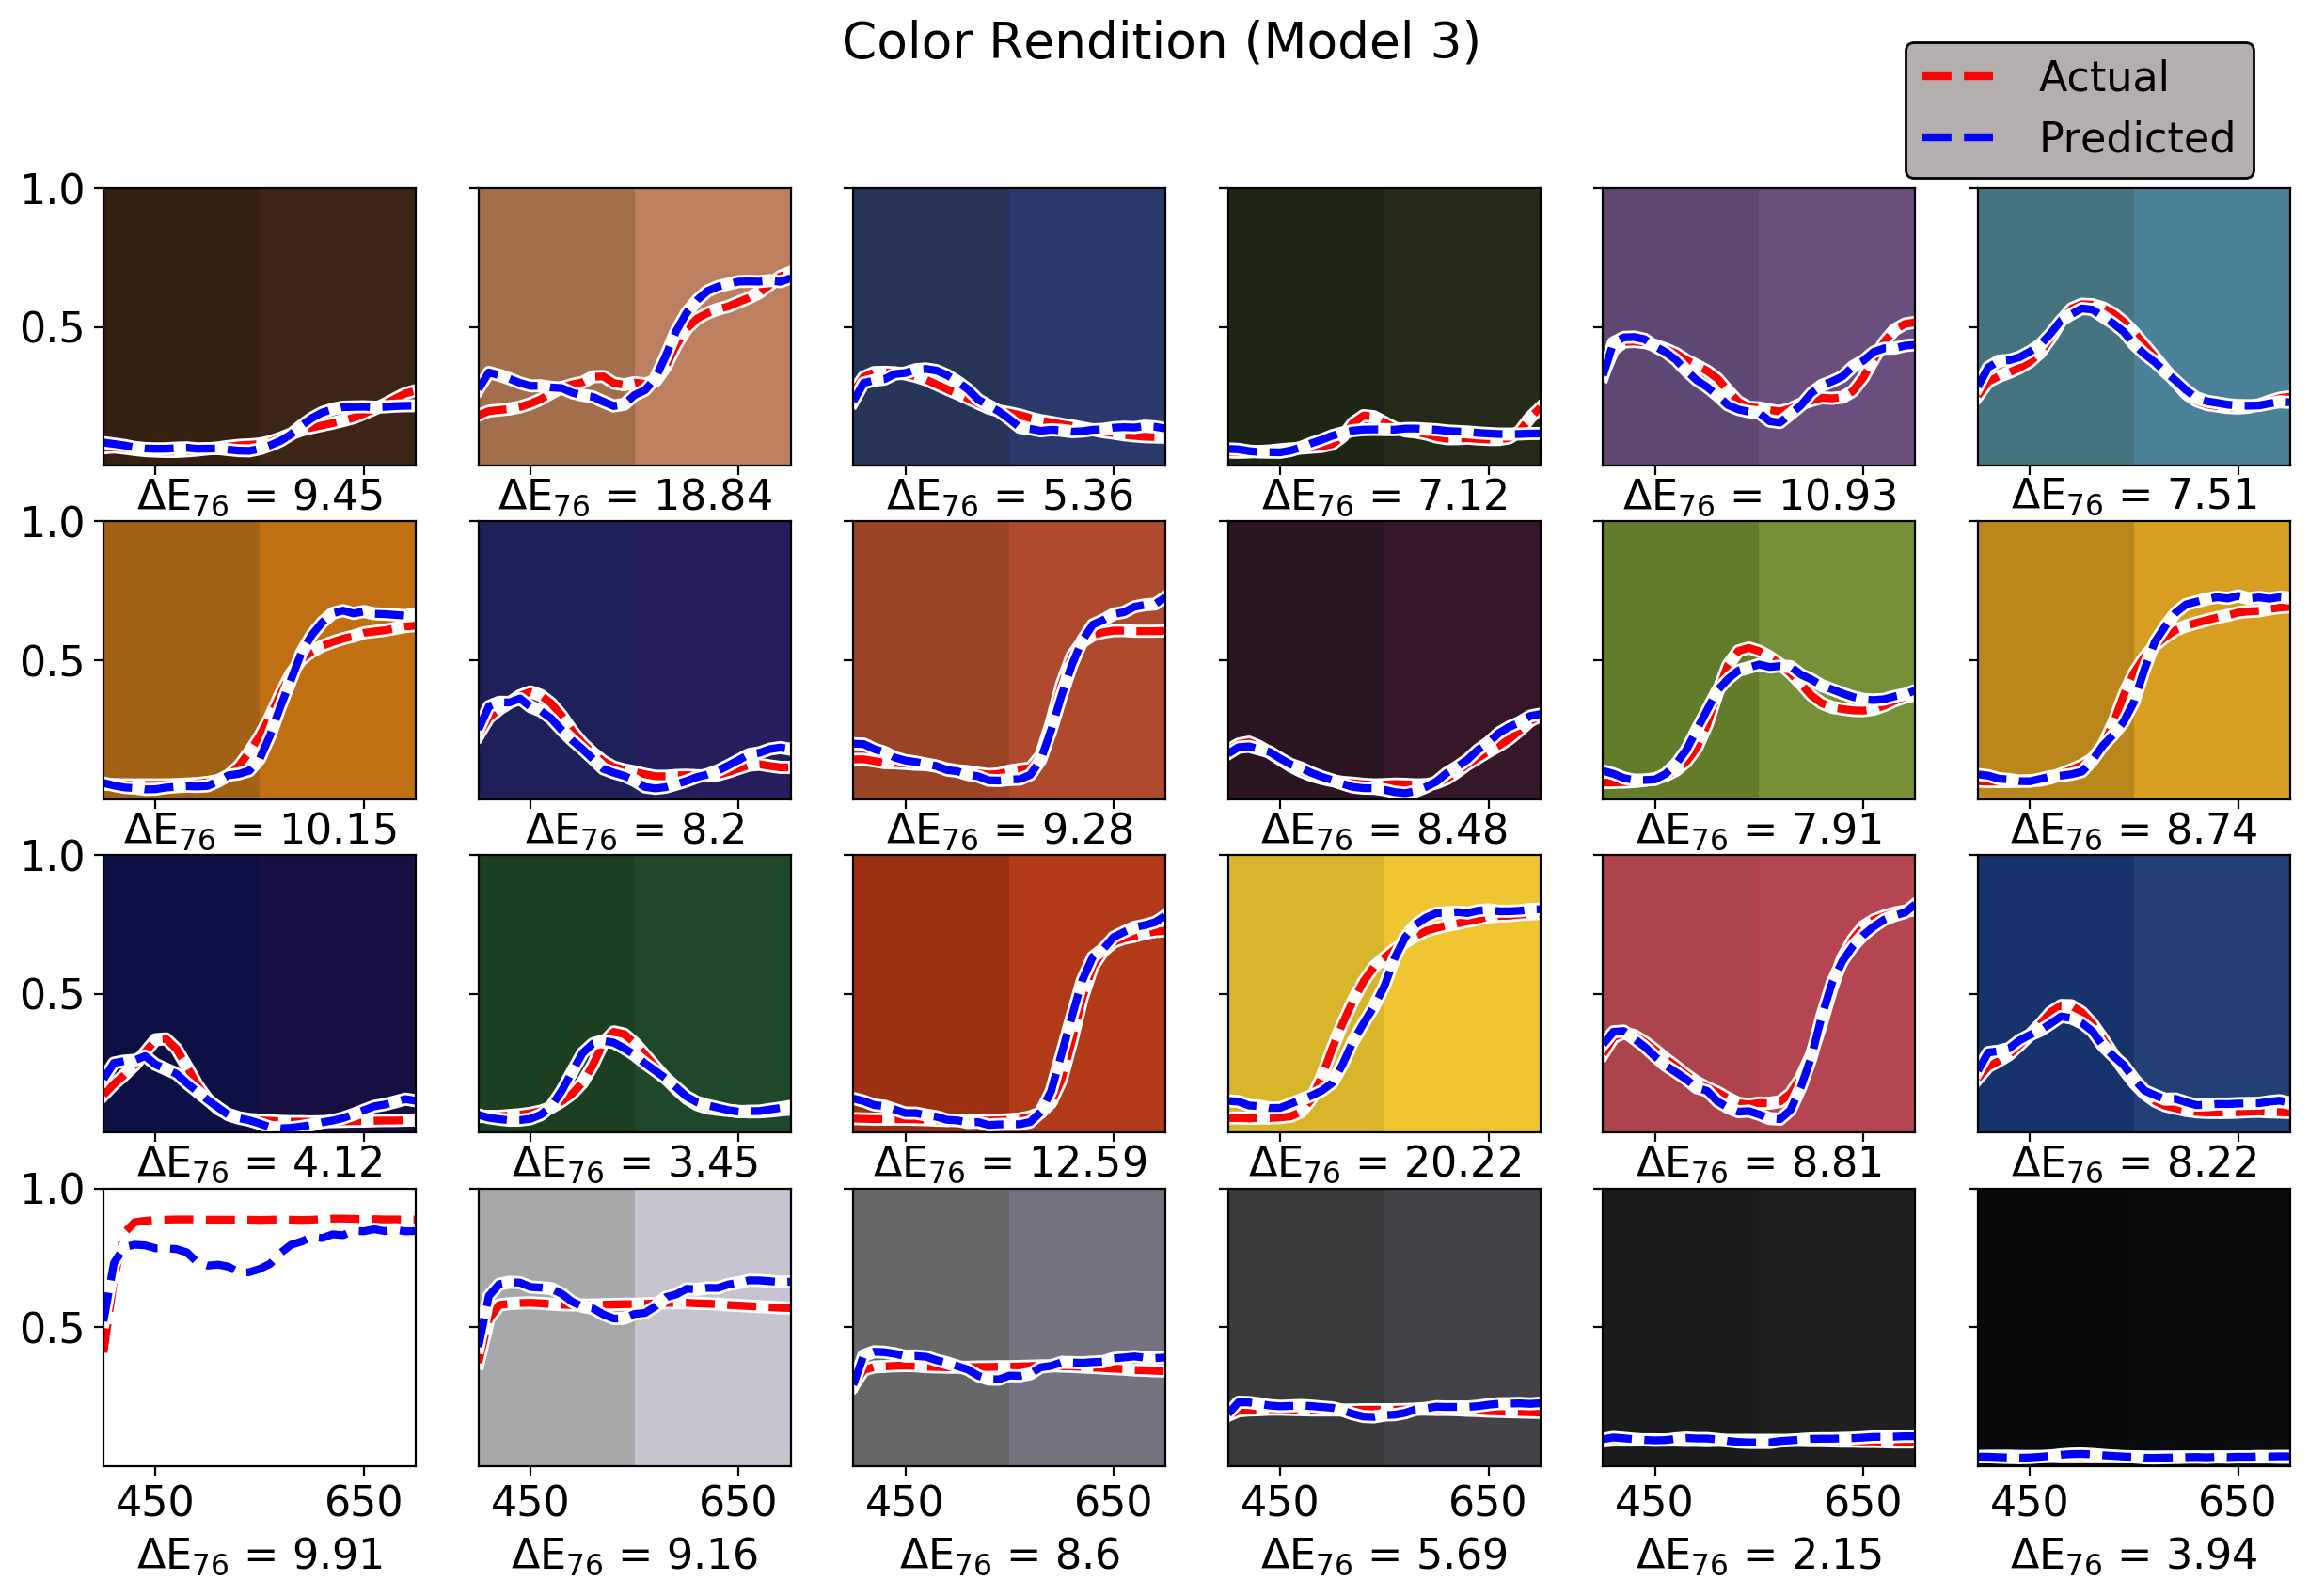

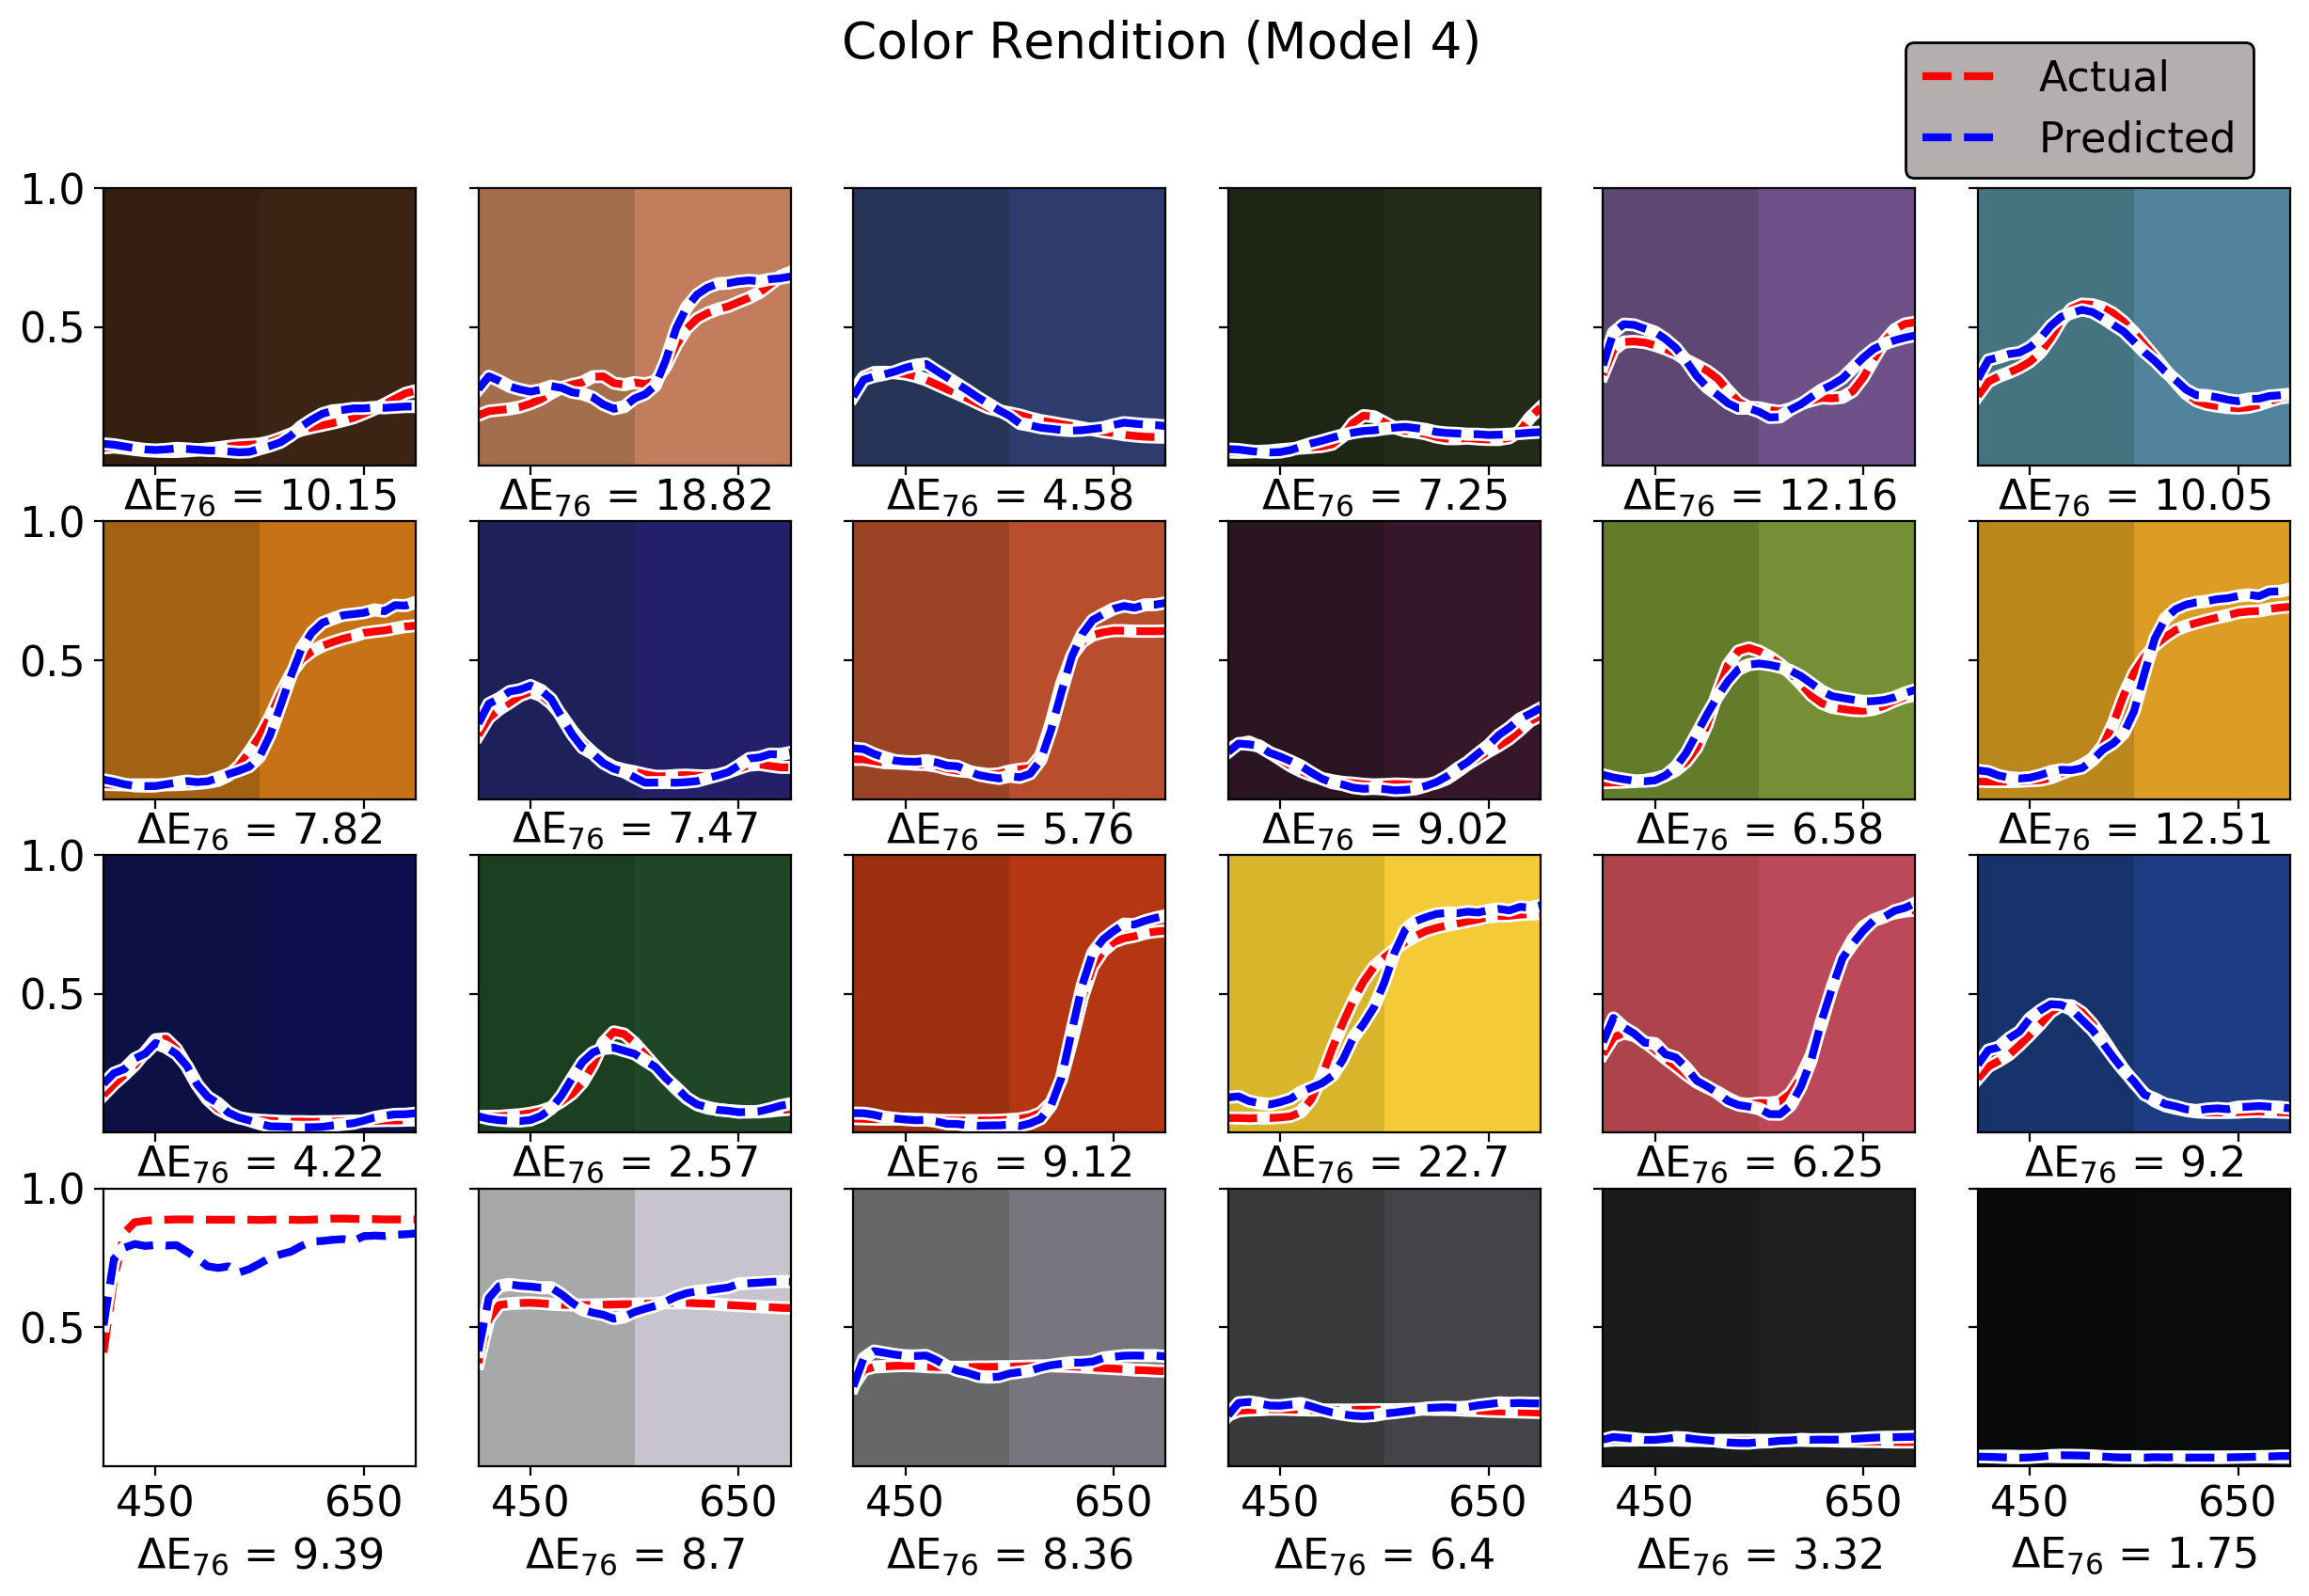

In [22]:
for model in MODELS:
    Render_WB(model, r,g,b,1)

In [23]:
def Macbeth_reconstruction(model, r_sensitivity,g_sensitivity,b_sensitivity, source, INDEX):
    RGB2REF = tf.keras.models.load_model(model)
    reflectances = RGB2REF.predict(RGB_mac.T)
    
    mod = MODELS.index(model)

    fig, axes = plt.subplots(1,3, figsize=(15,5), sharex=True, sharey=True, dpi=200, facecolor = 'w')
  
    R_w = np.trapz(reflectances[18,:]*r_sensitivity*source)
    G_w = np.trapz(reflectances[18,:]*g_sensitivity*source)
    B_w = np.trapz(reflectances[18,:]*b_sensitivity*source)


    R_m_w = np.trapz(macbeth_r[:,18]*r_sensitivity*source)
    G_m_w = np.trapz(macbeth_r[:,18]*g_sensitivity*source)
    B_m_w = np.trapz(macbeth_r[:,18]*b_sensitivity*source)

    RGB = []
    for i, ax in enumerate(axes.ravel()):
        
        de_76 = del_E(CIELab(reflectances[INDEX[i],:]),CIELab(macbeth_r[:,INDEX[i]]))
        
        

        R = 255/R_w*np.trapz(reflectances[INDEX[i],:]*r_sensitivity*source)
        G = 255/G_w*np.trapz(reflectances[INDEX[i],:]*g_sensitivity*source)
        B = 255/B_w*np.trapz(reflectances[INDEX[i],:]*b_sensitivity*source)
        
        R_m = 255/R_m_w*np.trapz(macbeth_r[:,INDEX[i]]*r_sensitivity*source)
        G_m = 255/G_m_w*np.trapz(macbeth_r[:,INDEX[i]]*g_sensitivity*source)
        B_m = 255/B_m_w*np.trapz(macbeth_r[:,INDEX[i]]*b_sensitivity*source) 
        
        if R<0: R = 0
        if G<0: G = 0
        if B<0: B = 0
        if R>255: R = 255
        if G>255: G = 255
        if G>255: B = 255
        
        #fig.suptitle("Color Rendition (MODEL " + str(mod+1) + ")")
        
        ax.plot(wavelength, macbeth_r[:,INDEX[i]], 'w-', lw = 5 )
        ax.plot(wavelength, macbeth_r[:,INDEX[i]], 'r--', lw = 3, label = 'Actual')
        ax.plot(wavelength, reflectances[INDEX[i],:], 'w-', lw = 5 )
        ax.plot(wavelength, reflectances[INDEX[i],:], 'b--', lw = 3, label = 'Predicted')
        ax.set_xlabel("$\Delta$E$_{76}$ = " + str(np.round(de_76,2)))

        x = reflectances[i,:]
        y = macbeth_r[:,i]
        mse = sum((x-y)**2)/len(x)
        rmse = np.sqrt(mse)
        alpha = np.arccos(sum(x*y)/(np.sqrt(sum(x**2))*(np.sqrt(sum(y**2)))))
        
        ax.text(410, 0.8, '$SAM$ = ' + str(np.round((alpha), 3)), color = 'w')
        ax.text(410, 0.9, '$RMSE$ = ' + str(np.round((np.sqrt(mse)), 3)), color = 'w')
        
        rr,gg,bb = R/255,G/255,B/255
        rr_m,gg_m,bb_m = R_m/255,G_m/255,B_m/255
        
        if rr<0: rr = 0
        if gg<0: gg = 0
        if gg<0:  bb = 0
        if rr>1: rr = 1
        if gg>1: gg = 1
        if bb>1: bb = 1
        
        #print(rr,gg,bb)
        ax.set_facecolor([rr,gg,bb])
             
        ax.set_xlim(400,700)
        ax.set_ylim(0,1)
        ax.set_xticks([450,650])
        ax.set_yticks([0.5,1])

        rect = patch.Rectangle((400,0),150,1,facecolor=([rr_m,gg_m,bb_m])) 
        ax.add_patch(rect)
        RGB.append([rr,gg,bb])
    
        

    legend = ax.legend(bbox_to_anchor=(0.35,0.25), fancybox = True)
    frame = legend.get_frame() #sets up for color, edge, and transparency
    frame.set_facecolor('#b4aeae') #color of legend
    frame.set_edgecolor('black') #edge color of legend
    frame.set_alpha(1) #deals with transparency
    fig.savefig(results_path + "closer_look_" + model + ".png", bbox_inches='tight')
    

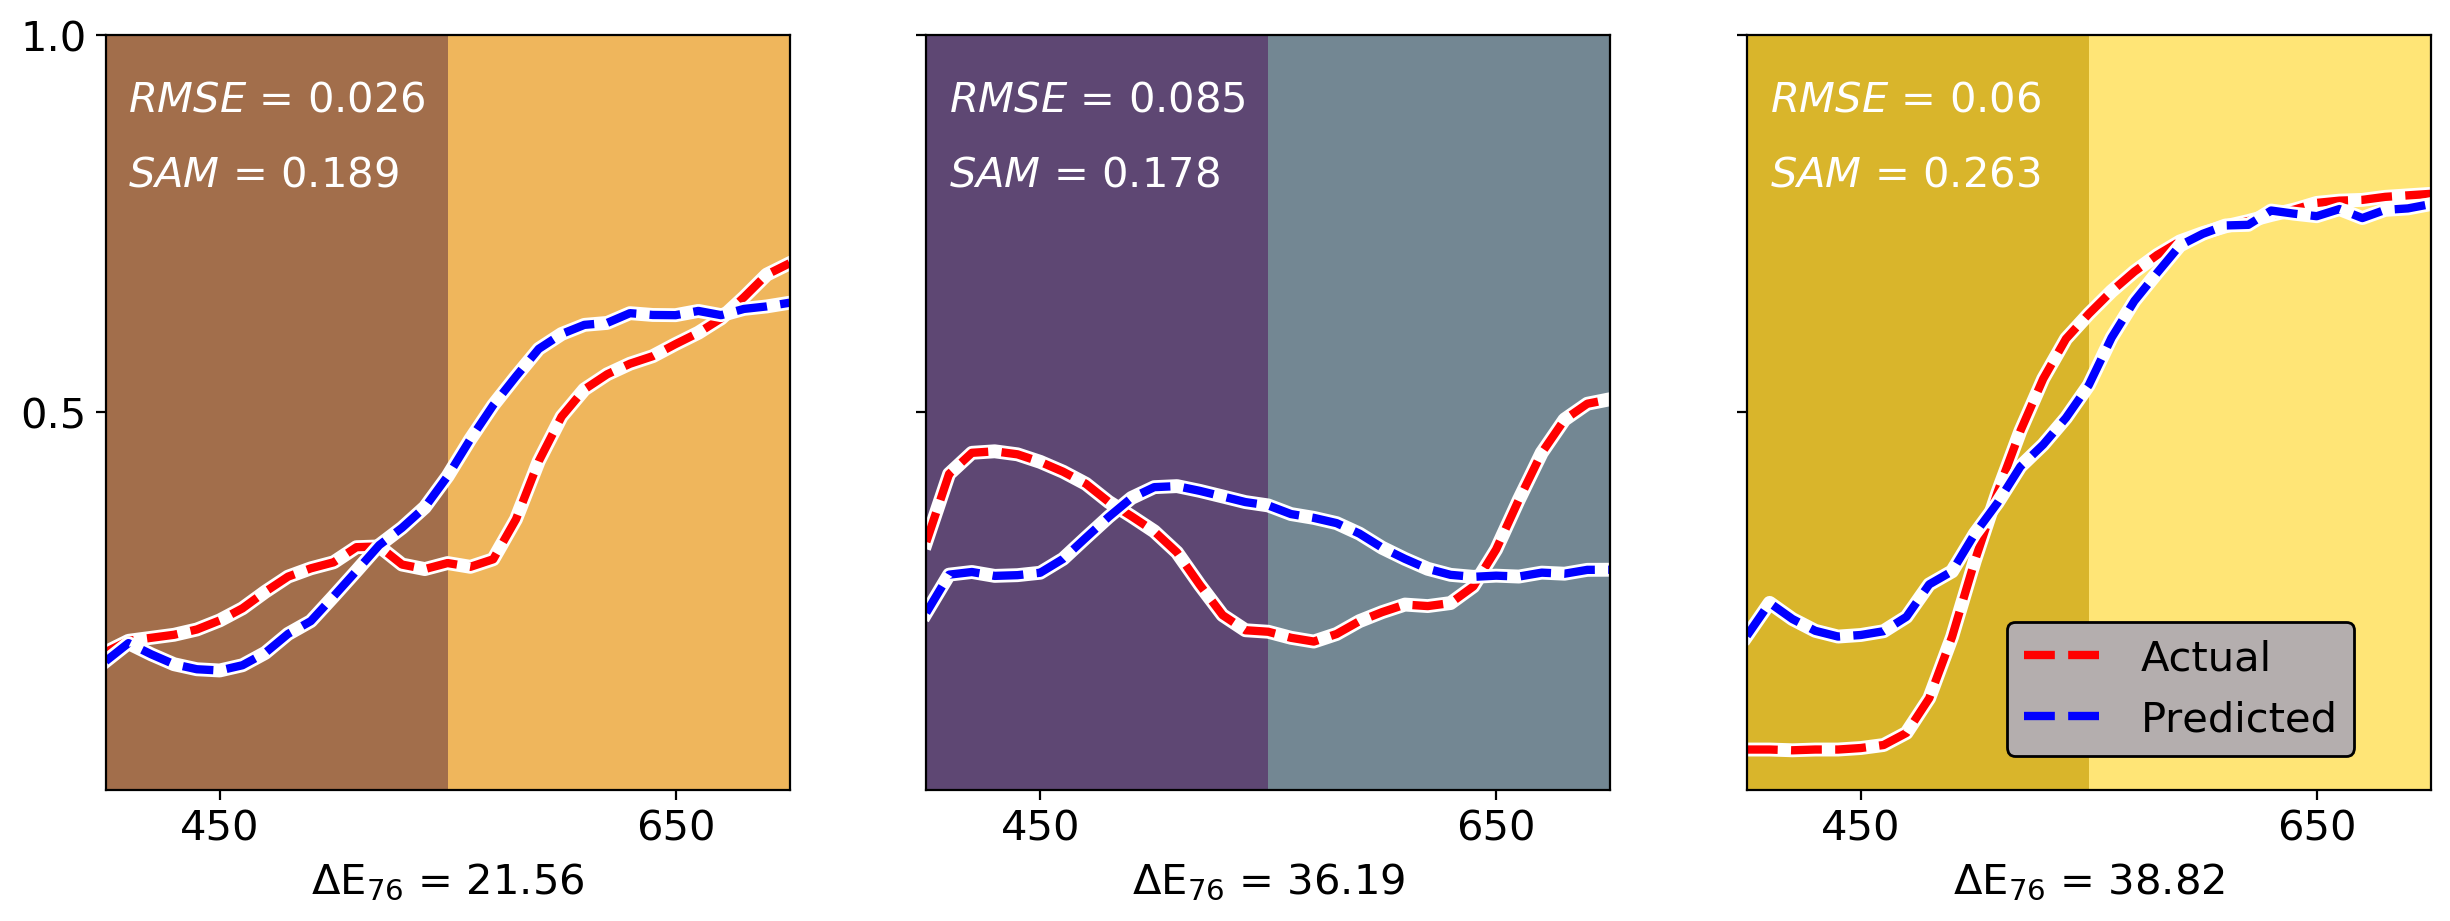

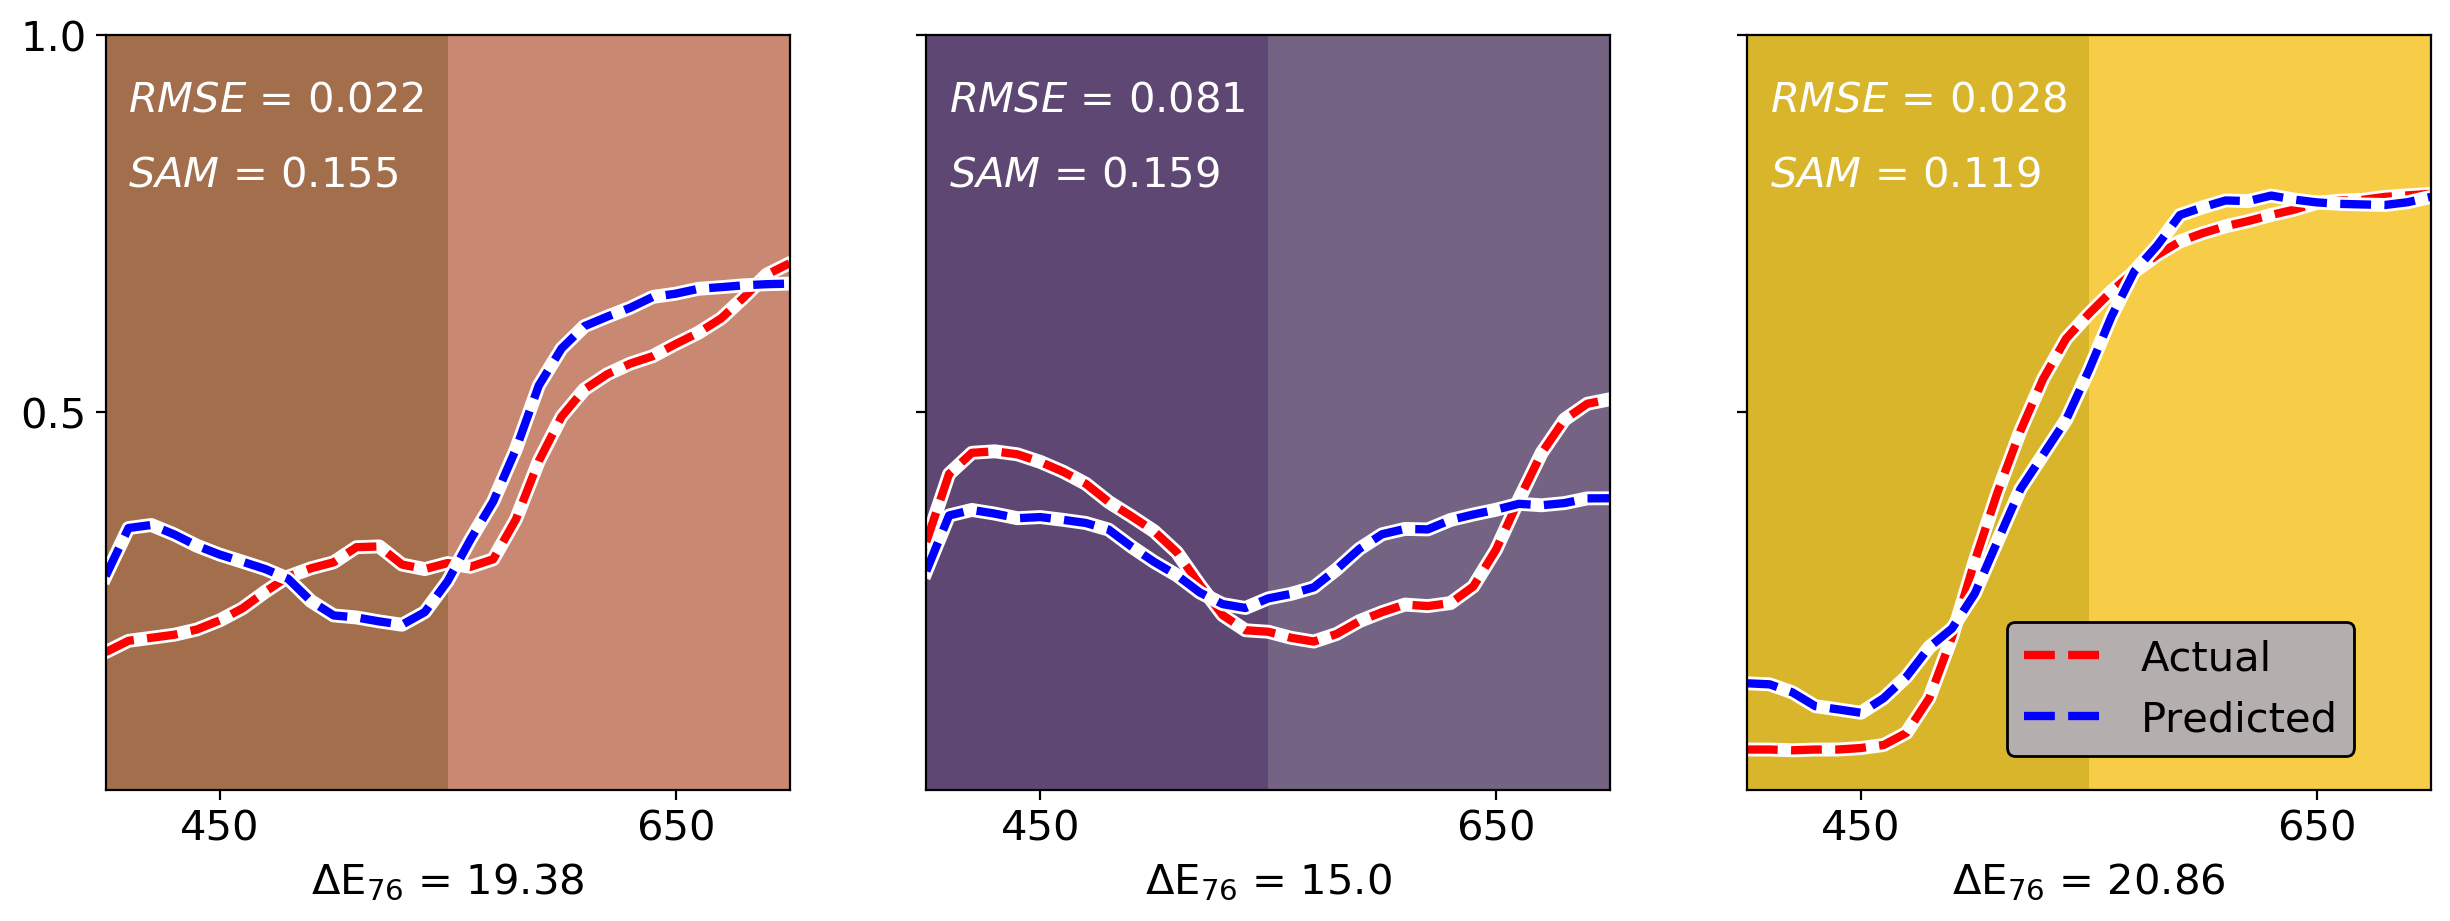

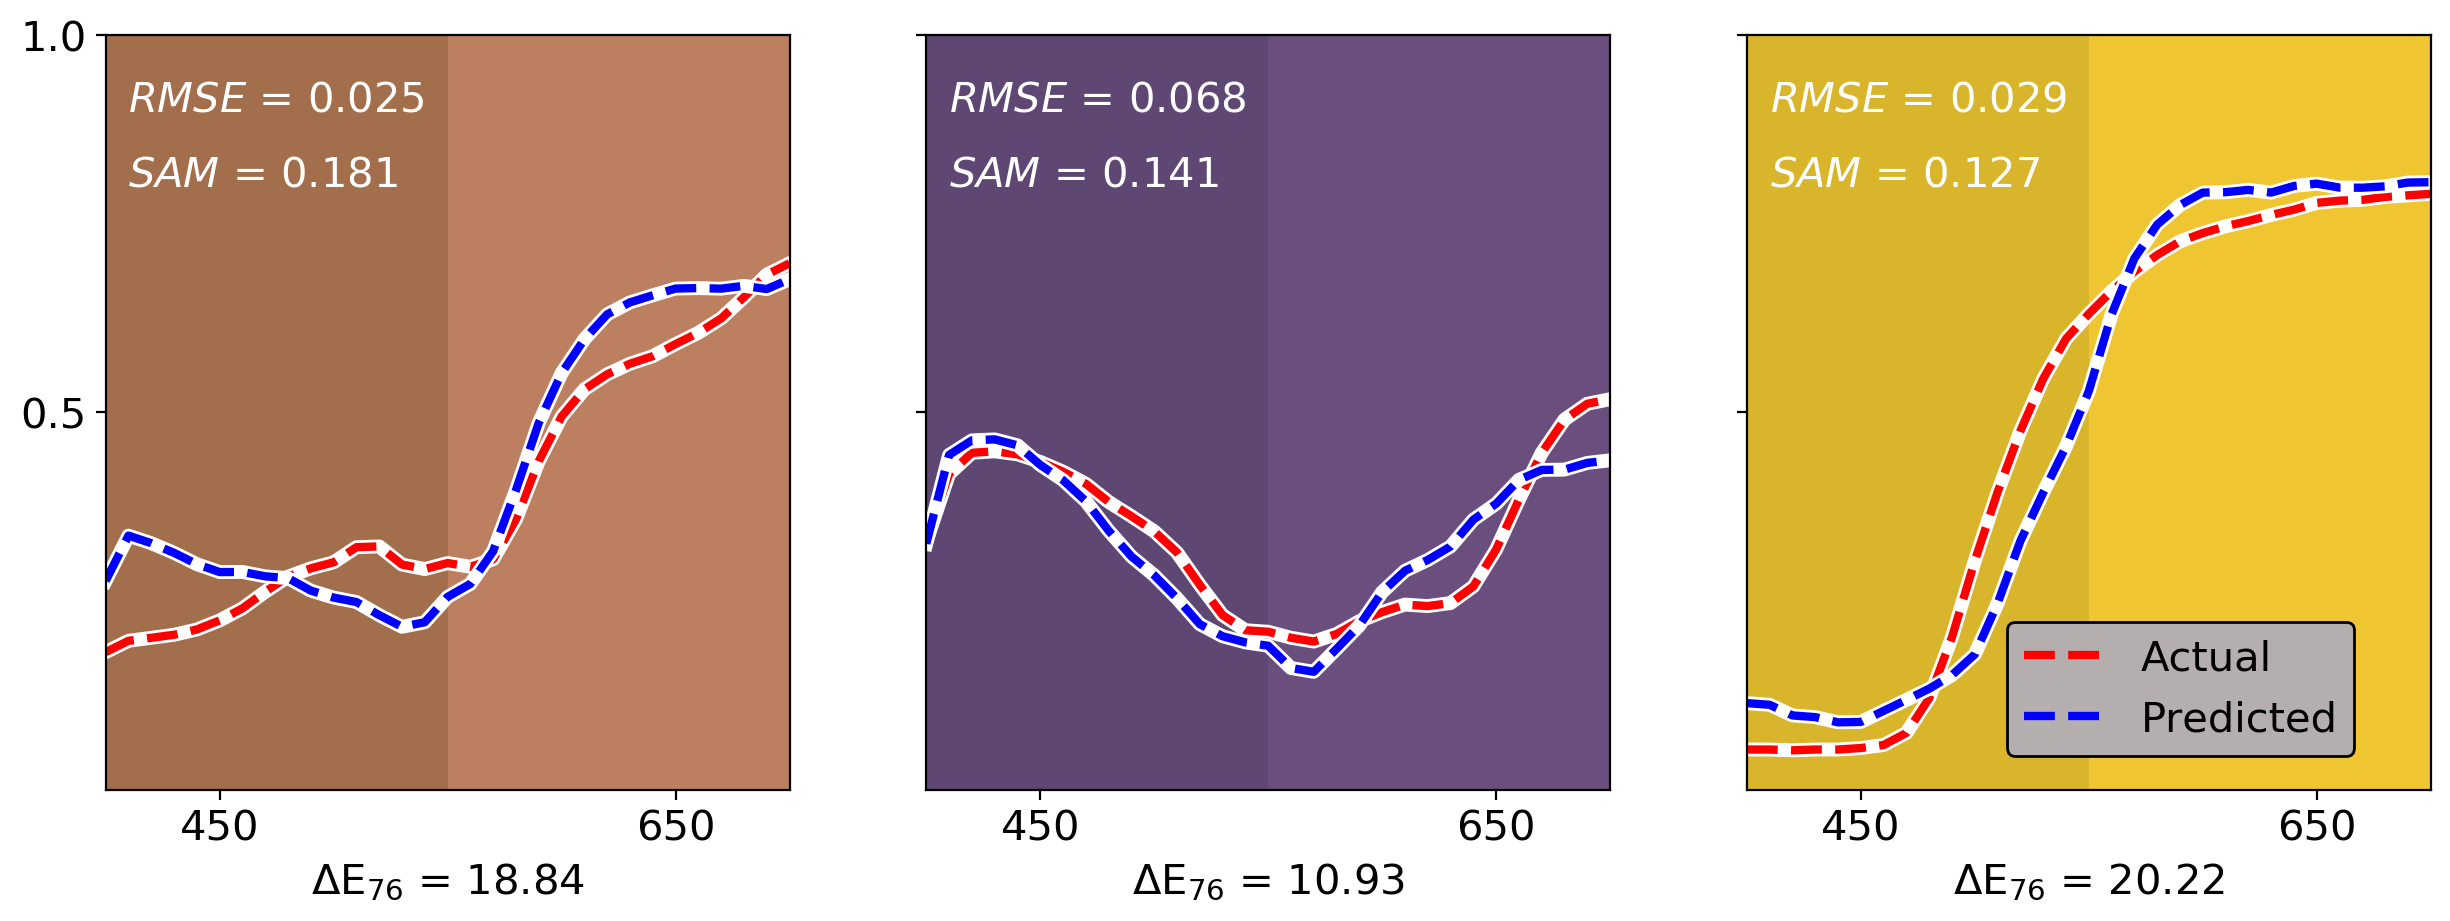

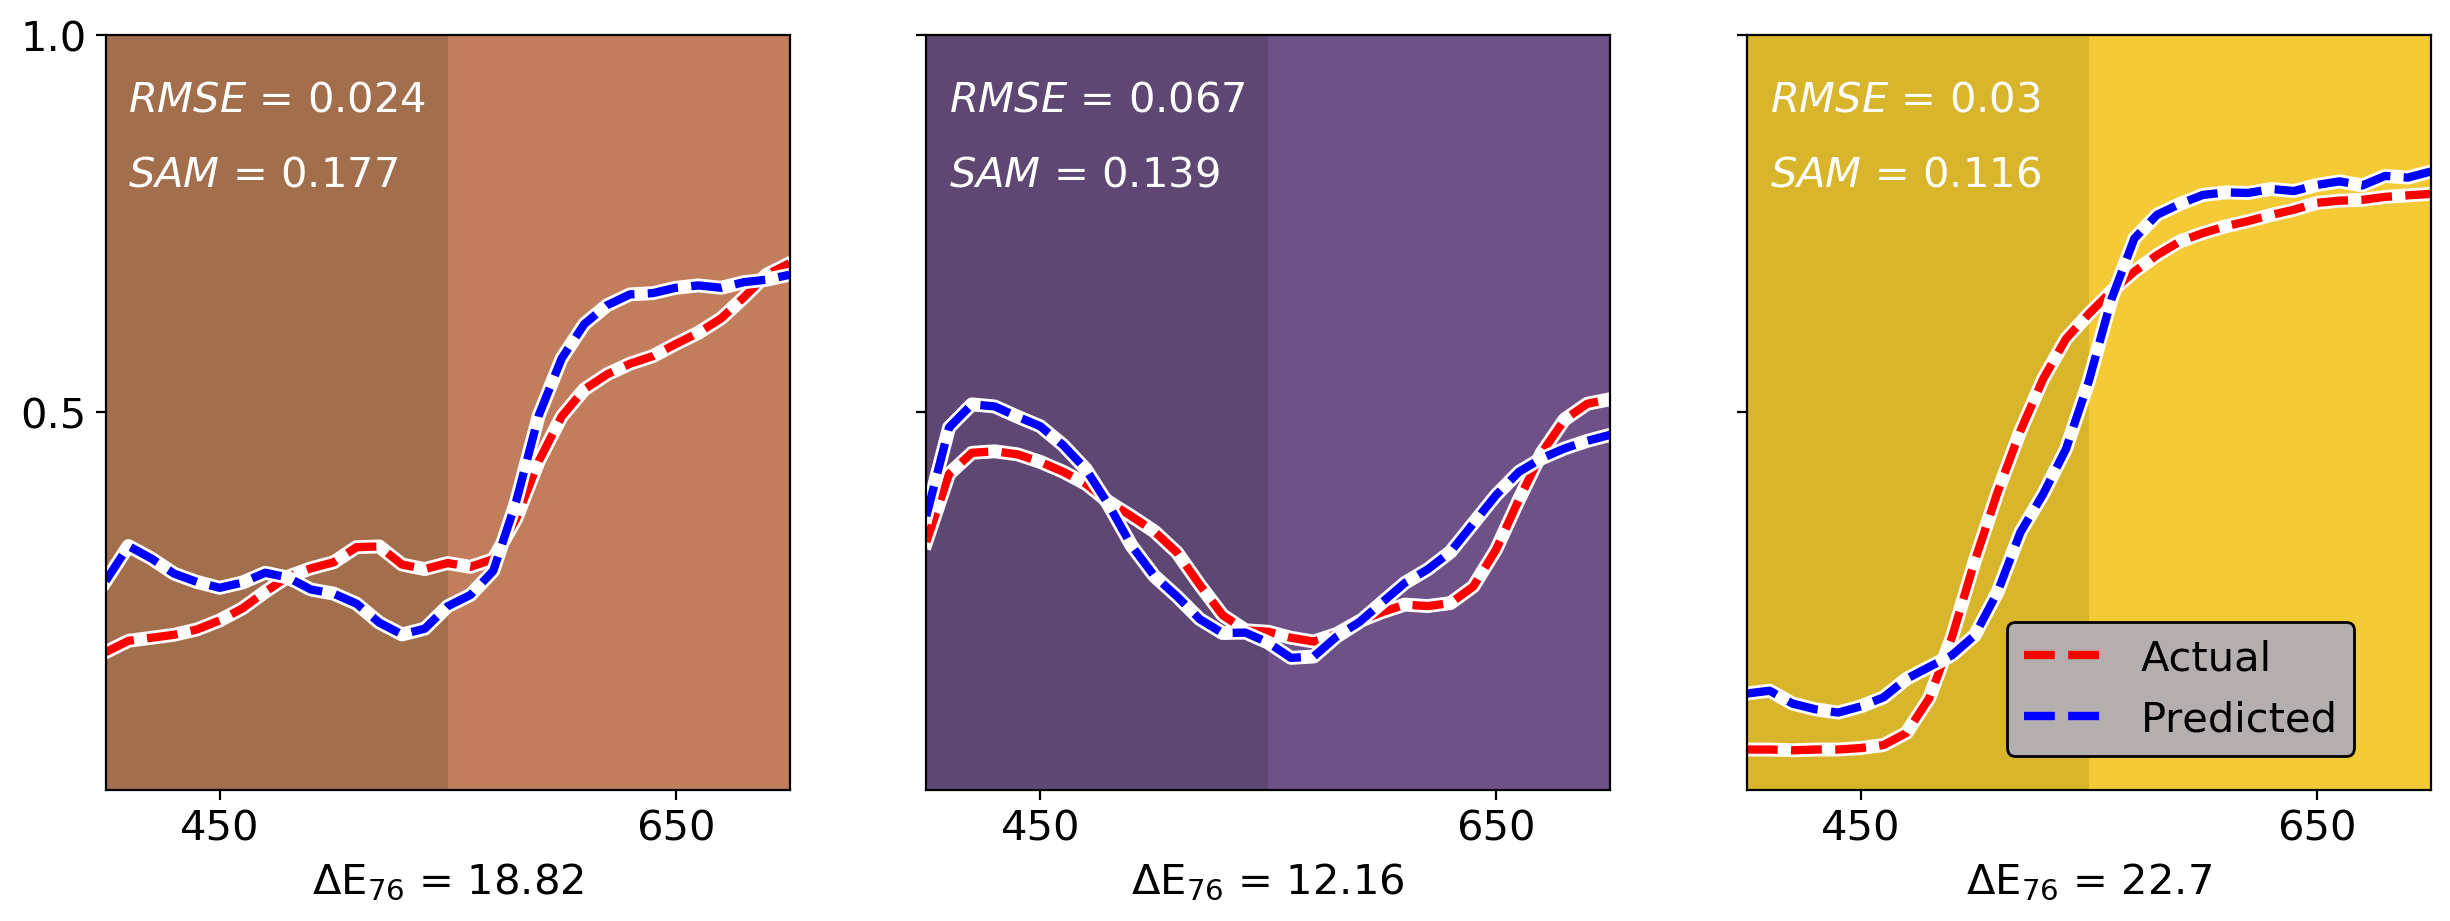

In [57]:
for model in MODELS:
    Macbeth_reconstruction(model, r,g,b,1, [1,4,15])

C:\Users\renep\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\renep\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\renep\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fut

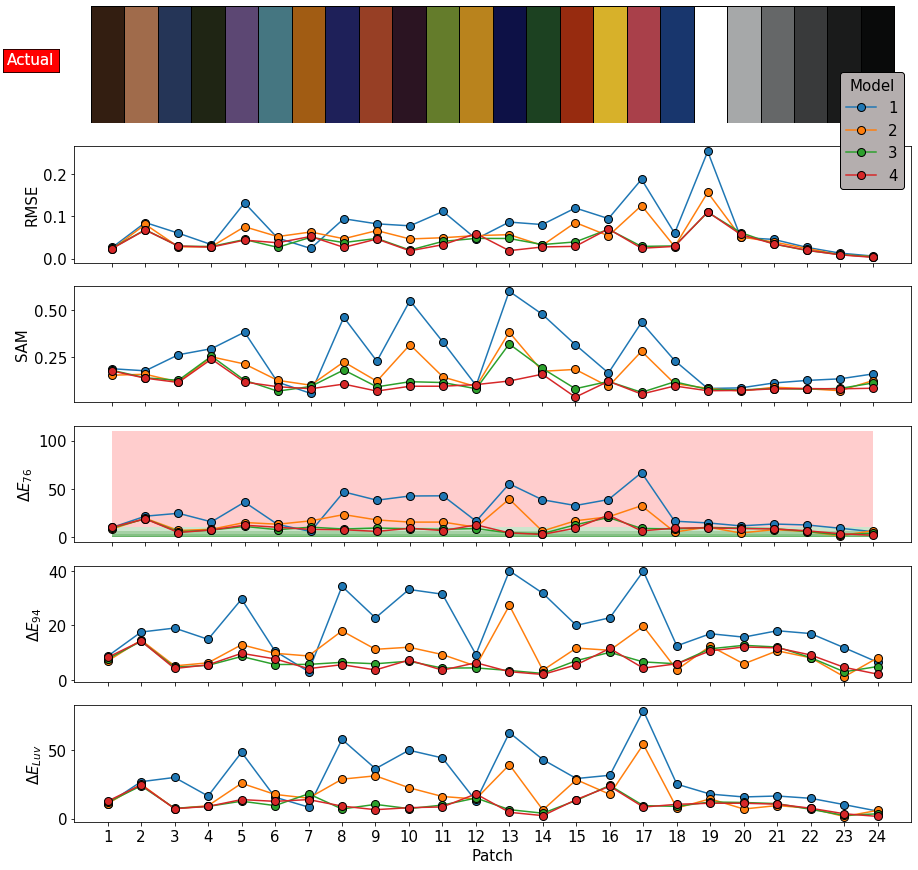

In [24]:
plt.figure(figsize=[15,15], facecolor = 'w')
plt.rcParams['axes.titlesize'] = 15
plt.rcParams.update({'font.size': 15})

RMSE_overall, SAM_overall, DE_76_overall, DE_CH_ab_overall, DE_CH_uv_overall = [],[],[],[],[]

for models in MODELS:
    mod = MODELS.index(model)

    
    RMSE, SAM, DE_76, DE_CH_ab, DE_CH_uv = Error(models)
    
    RMSE_overall.append(RMSE)
    SAM_overall.append(SAM)
    DE_76_overall.append(DE_76)
    DE_CH_ab_overall.append(DE_CH_ab)
    DE_CH_uv_overall.append(DE_CH_uv)

    ax1 = plt.subplot(611)
    for i in range(24):
        plt.gca().add_patch(patch.Rectangle((i+0.5,0),1,1, ec = 'k', facecolor = RGB_mac[:,i]/255))
        plt.text(-2,0.5, "Actual", fontsize = 15, color = 'w',bbox=dict(facecolor='r', alpha=0.5))

    plt.xticks(np.arange(24)+1)
    plt.xlim(0,25)
    plt.setp(ax1.get_yticklabels(), visible=False)
    plt.axis("off")

    ax2 = plt.subplot(612)
    plt.plot(np.arange(24)+1,RMSE, 'o-', ms = 8, mec = 'k')
    plt.grid()
    plt.ylabel("RMSE")
    plt.xticks(np.arange(24)+1)
    #plt.ylim(0,0.2)
    plt.setp(ax2.get_xticklabels(), visible=False)

    ax3 = plt.subplot(613)
    plt.plot(np.arange(24)+1,SAM, 'o-', ms = 8, mec = 'k')
    plt.grid()
    plt.ylabel("SAM")
    #plt.ylim(0,0.3)
    plt.xticks(np.arange(24)+1)
    plt.setp(ax3.get_xticklabels(), visible=False)

    ax4 = plt.subplot(614)
    plt.plot(np.arange(24)+1,DE_76, 'o-', ms = 8, mec = 'k')
    plt.grid()
    plt.ylabel("$\Delta E_{76}$")
    plt.gca().add_patch(patch.Rectangle((1,0),23,1, facecolor = 'g', alpha = 0.20))
    plt.gca().add_patch(patch.Rectangle((1,1),23,2, facecolor = 'g', alpha = 0.15))
    plt.gca().add_patch(patch.Rectangle((1,3),23,3, facecolor = 'g', alpha = 0.10))
    plt.gca().add_patch(patch.Rectangle((1,6),23,4, facecolor = 'g', alpha = 0.05))
    plt.gca().add_patch(patch.Rectangle((1,10),23,100, facecolor = 'r', alpha = 0.05))

    plt.xticks(np.arange(24)+1)
    #plt.ylim(0,30)
    plt.setp(ax4.get_xticklabels(), visible=False)

    ax5 = plt.subplot(615, sharex=ax1)
    plt.plot(np.arange(24)+1,DE_CH_ab, 'o-', ms = 8, mec = 'k')
    plt.grid()
    plt.ylabel("$\Delta E_{94}$")
    #plt.ylim(0,30)
    plt.xticks(np.arange(24)+1)
    plt.xlim(0,25)
    plt.setp(ax5.get_xticklabels(), visible=False)

    
    ax6 = plt.subplot(616, sharex=ax1)
    plt.plot(np.arange(24)+1,DE_CH_uv, 'o-', ms = 8, mec = 'k')#, label = str(mod+1))
    plt.grid()
    plt.xlabel("Patch")
    plt.ylabel("$\Delta E_{Luv}$")
    #plt.ylim(0,20)
    plt.xticks(np.arange(24)+1)
    plt.xlim(0,25)

legend = plt.legend(["1","2","3","4"],bbox_to_anchor=(1,6.5), fancybox = True, title="Model")
frame = legend.get_frame() #sets up for color, edge, and transparency
frame.set_facecolor('#b4aeae') #color of legend
frame.set_edgecolor('black') #edge color of legend
frame.set_alpha(1) #deals with transparency
plt.show()


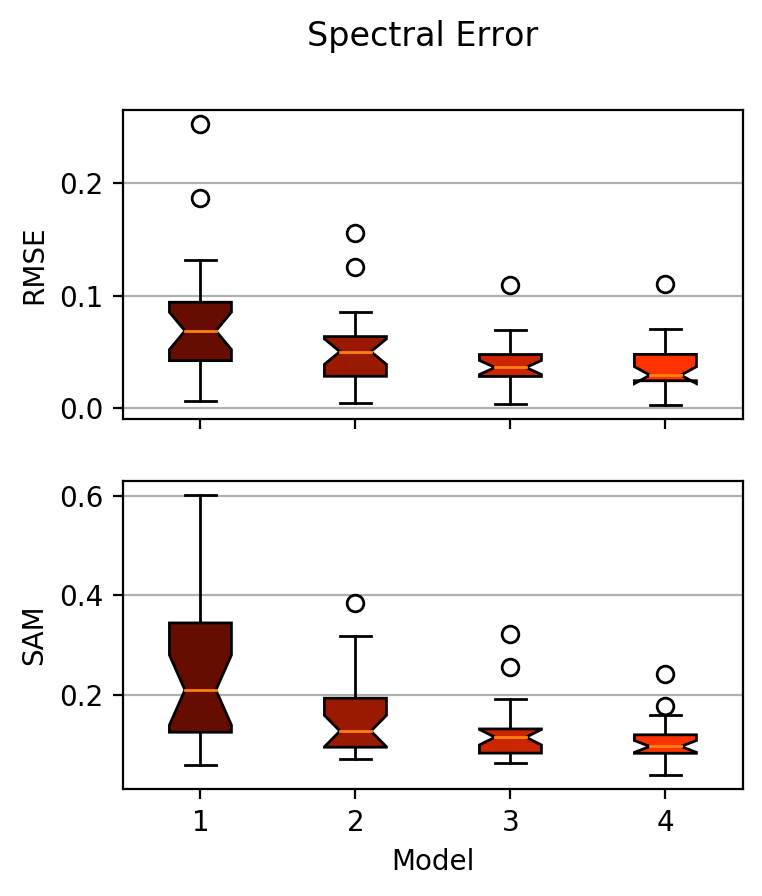

In [56]:
plt.figure(figsize=[4,4.5], facecolor = 'w', dpi = 200)
plt.rcParams['axes.titlesize'] = 15
plt.rcParams.update({'font.size': 10})

colors = [[0.4,0.05,0], [0.6,0.1,0], [0.8,0.15,0], [1,0.2,0]]

plt.suptitle("Spectral Error")
ax1 = plt.subplot(211)

box1 = plt.boxplot(RMSE_overall, notch = True, widths = 0.4, patch_artist=True)
plt.xticks(np.arange(len(MODELS))+1)
#plt.ylim(0,0.5)
plt.ylabel("RMSE")
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.yaxis.grid(True)

for patch, color in zip(box1['boxes'], colors):
    patch.set_facecolor(color)

ax2 = plt.subplot(212)
box2 = plt.boxplot(SAM_overall, notch = True, widths = 0.4, patch_artist=True)
plt.xticks(np.arange(len(MODELS))+1)
ax2.yaxis.grid(True)

plt.ylabel("SAM")
#plt.setp(ax2.get_xticklabels(), visible=False)

for patch, color in zip(box2['boxes'], colors):
    patch.set_facecolor(color)
    
plt.xlabel("Model")
plt.savefig(results_path + "macbeth_spectral_error.png", bbox_inches='tight', transparent = True)


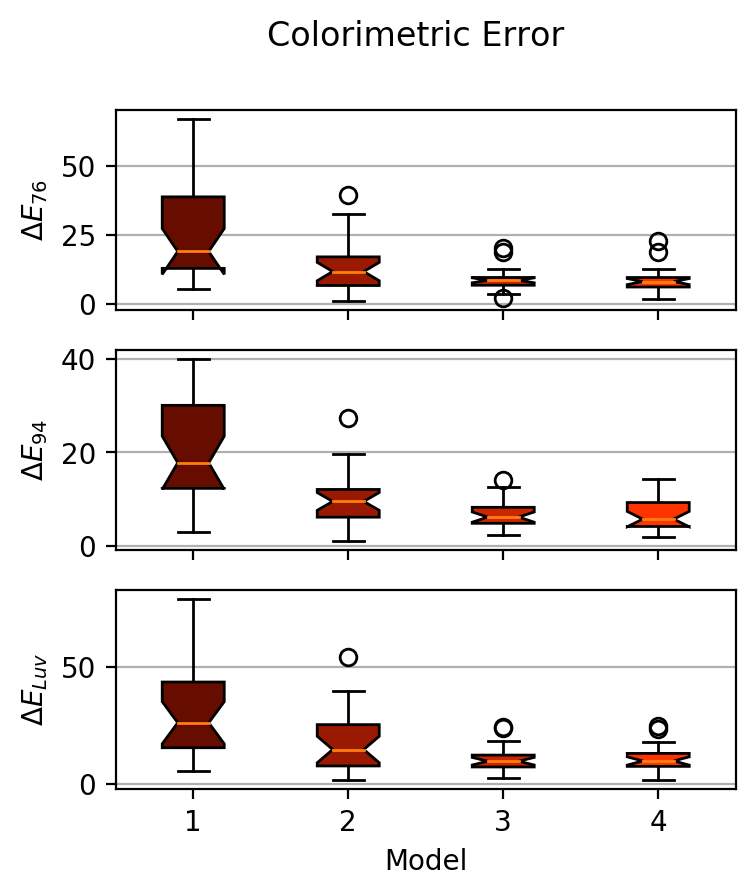

In [57]:
plt.figure(figsize=[4,4.5], facecolor = 'w', dpi = 200)
plt.rcParams['axes.titlesize'] = 15
plt.rcParams.update({'font.size': 10})
plt.suptitle("Colorimetric Error")
ax1 = plt.subplot(311)

box3 = plt.boxplot(DE_76_overall, notch = True, widths = 0.4, patch_artist=True)
plt.xticks(np.arange(len(MODELS))+1)
#plt.ylim(0,25)

for patch, color in zip(box3['boxes'], colors):
    patch.set_facecolor(color)
    
plt.ylabel("$\Delta E_{76}$")
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.yaxis.grid(True)


ax2 = plt.subplot(312)

box4 = plt.boxplot(DE_CH_ab_overall, notch = True, widths = 0.4, patch_artist=True)
plt.xticks(np.arange(len(MODELS))+1)
#plt.ylim(0,20)
plt.ylabel("$\Delta E_{94}$")
plt.setp(ax2.get_xticklabels(), visible=False)

for patch, color in zip(box4['boxes'], colors):
    patch.set_facecolor(color)
ax2.yaxis.grid(True)
    
    
ax3 = plt.subplot(313)
box5 = plt.boxplot(DE_CH_uv_overall, notch = True, widths = 0.4, patch_artist=True)
plt.xticks(np.arange(len(MODELS))+1)
#plt.ylim(0,20)
ax3.yaxis.grid(True)

plt.ylabel("$\Delta E_{Luv}$")
plt.xlabel("Model")

for patch, color in zip(box5['boxes'], colors):
    patch.set_facecolor(color)
    
plt.savefig(results_path + "macbeth_colorimetric_error.png", bbox_inches='tight', transparent = True)


In [60]:
for model in MODELS:
    MODEL = tf.keras.models.load_model(model)
    #plt.title(str(MODEL))
    MODEL.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_105 (Dense)            (None, 3)                 12        
_________________________________________________________________
dense_106 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_107 (Dense)            (None, 31)                341       
Total params: 393
Trainable params: 393
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_108 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_109 (Dense)            (None, 20)                220       
________________________________